In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import skimage
import math
from skimage.io import imsave, imread
from skimage.transform import resize
from PIL import Image
from shutil import copyfile
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD, Adadelta, Adam
from keras.applications.mobilenet import MobileNet
from keras_squeezenet import SqueezeNet
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.layers import BatchNormalization
from keras.optimizers import RMSprop

from keras.utils import np_utils


%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from preprocess import load_dir, preprocess_and_save_images, divide_to_train_end_test
from custom_metrics import precision, recall, fmeasure

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1" 

In [4]:
%%time
# Firstly load all datasets

X_128_F_ByShape, y_128_F_ByShape = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByShape_128_3dim",
                                            ["A4", "Slip", "Ticket"],
                                            already_transformed=True)   

X_160_F_ByShape, y_160_F_ByShape = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByShape_160_3dim",
                                            ["A4", "Slip", "Ticket"],
                                            already_transformed=True)   

X_192_F_ByShape, y_192_F_ByShape = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByShape_192_3dim",
                                            ["A4", "Slip", "Ticket"],
                                            already_transformed=True)   

X_224_F_ByShape, y_224_F_ByShape = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByShape_224_3dim",
                                            ["A4", "Slip", "Ticket"],
                                            already_transformed=True)   
#Than divide all of them to train and test

X_train_128_FS, y_train_128_FS, X_test_128_FS, y_test_128_FS = divide_to_train_end_test(X_128_F_ByShape,
                                                                                        y_128_F_ByShape, num_categories=3)
X_train_160_FS, y_train_160_FS, X_test_160_FS, y_test_160_FS = divide_to_train_end_test(X_160_F_ByShape,
                                                                                        y_160_F_ByShape, num_categories=3)
X_train_192_FS, y_train_192_FS, X_test_192_FS, y_test_192_FS = divide_to_train_end_test(X_192_F_ByShape,
                                                                                        y_192_F_ByShape, num_categories=3)
X_train_224_FS, y_train_224_FS, X_test_224_FS, y_test_224_FS = divide_to_train_end_test(X_224_F_ByShape,
                                                                                        y_224_F_ByShape, num_categories=3)

Wall time: 28.7 s


In [5]:
# Create two pandas tables
# One with parameters, and one - with results

parameters_df = pd.DataFrame(columns=['net_name', 'dataset_name', 'train_or_test', 'image_size', 'batch_size_app',
                                      'batch_size_small_net', 'dense_1', 'dense_2', 'activation_1', 'activation_2', 'optimiser'])
results_df = pd.DataFrame(columns=['net_name', 'dataset_name', 'train_or_test',
                                   'loss', 'accuracy', 'precision', 'recall', 'fmeasure'])


In [4]:
def shuffle_Xy(X, y):
    perm = np.random.permutation(len(X))
    return np.array(X)[perm], np.array(y)[perm]

In [5]:
def create_net_with_name(net_name, X_train):
    if net_name == 'MobileNet':
        return MobileNet(input_shape=X_train[0].shape, include_top=False)
    if net_name == 'SqueezeNet':
        return SqueezeNet(input_shape=X_train[0].shape, include_top=False)
    if net_name == 'Xception':
        return Xception(input_shape=X_train[0].shape, include_top=False)
    if net_name == 'VGG16':
        return VGG16(input_shape=X_train[0].shape, include_top=False)
    if net_name == 'VGG19':
        return VGG19(input_shape=X_train[0].shape, include_top=False)
    if net_name == 'ResNet50':
        return ResNet50(input_shape=X_train[0].shape, include_top=False)
    if net_name == 'InceptionV3':
        return InceptionV3(input_shape=X_train[0].shape, include_top=False)
    if net_name == 'InceptionResNetV2':
        return InceptionResNetV2(input_shape=X_train[0].shape, include_top=False)    
    

In [6]:
def one_hot(y, classes_count):
    return np.eye(classes_count)[y]

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
def create_and_run_net(net_name, categories_count, X_train, y_train, X_test, y_test, batch_size_small_net, dense_1, dense_2, epoch_count):
    
    X_train_shuffled, y_train_shuffled = shuffle_Xy(X_train, y_train)
    
    model_app = create_net_with_name(net_name, X_train_shuffled)
    model_app.trainable = True

    model = Sequential()
    model.add(model_app)
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(categories_count, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, fmeasure])
    callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')
    history_callback = model.fit(X_train_shuffled, one_hot(y_train_shuffled, categories_count),
                                 epochs=epoch_count, batch_size=batch_size_small_net, callbacks=[callback])
    
    scores_test = model.evaluate(X_test, one_hot(y_test, categories_count))
    
    ### CONFUSION MATRIX 
    
    y_pred_train = model.predict(X_train)
    cnf_matrix = confusion_matrix(one_hot(y_train, categories_count).argmax(axis=1), (y_pred_train.round()).argmax(axis=1))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

    y_pred_test = model.predict(X_test)
    cnf_matrix = confusion_matrix(one_hot(y_test, categories_count).argmax(axis=1), (y_pred_test.round()).argmax(axis=1))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()
    
    
    return history_callback, scores_test


In [9]:
def run_net_and_write_result(parameters_df, results_df, net_name, dataset_name, categories_count, image_size, X_train, y_train, X_test, y_test,
                            batch_size_small_net, dense_1, dense_2, epoch_count):
    history_callback, scores_test = create_and_run_net(net_name, categories_count, X_train, y_train, X_test, y_test, batch_size_small_net,
                                                      dense_1, dense_2, epoch_count)
    
    loss_best = min(history_callback.history['loss'])
    accuracy_best = max(history_callback.history['acc'])
    precision_best = max(history_callback.history['precision'])
    recall_best = max(history_callback.history['recall'])
    fmeasure_best = max(history_callback.history['fmeasure'])
    
    # write in dataframes
    parameters = {'net_name':net_name, 'dataset_name':dataset_name, 
                  'train_or_test':'train', 'image_size':image_size, 
                  'batch_size_app':-1, 'batch_size_small_net':batch_size_small_net, 'dense_1':dense_1, 'dense_2':dense_2,
                  'activation_1':'relu', 'activation_2':'relu', 'optimiser':'adam'}
    parameters_df = parameters_df.append(parameters, ignore_index=True)
    results = {'net_name':net_name,'dataset_name':dataset_name, 'train_or_test':'train',
               'loss':loss_best, 'accuracy':accuracy_best, 'precision':precision_best,
               'recall':recall_best, 'fmeasure':fmeasure_best}
    results_df = results_df.append(results, ignore_index=True)
    
    # evaluate on test
    parameters = {'net_name':net_name, 'dataset_name':dataset_name, 
                  'train_or_test':'test', 'image_size':image_size, 
                  'batch_size_app':-1, 'batch_size_small_net':batch_size_small_net, 'dense_1':dense_1, 'dense_2':dense_2,
                  'activation_1':'relu', 'activation_2':'relu', 'optimiser':'adam'}
    parameters_df = parameters_df.append(parameters, ignore_index=True)
    results = {'net_name':net_name,'dataset_name':dataset_name, 'train_or_test':'test',
               'loss':scores_test[0], 'accuracy':scores_test[1],
               'precision':scores_test[2], 'recall':scores_test[3], 'fmeasure':scores_test[4]}
    results_df = results_df.append(results, ignore_index=True)
    
    parameters_df.to_csv('./PARAMETERS_AND_RESULTS/11_04_params_France_WITH_RETRAIN.csv', sep='\t')
    results_df.to_csv('./PARAMETERS_AND_RESULTS/11_04_results_France_WITH_RETRAIN.csv', sep='\t')
    
    return parameters_df, results_df
    

In [13]:
## MobileNet, 128

In [16]:
X_train_shuffled, y_train_shuffled = shuffle_Xy(X_train_128_FS, y_train_128_FS)

In [23]:
model_app = create_net_with_name('MobileNet', X_train_shuffled)
model_app.trainable = True

In [24]:
%%time
model = Sequential()
model.add(model_app)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, fmeasure])
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')
history_callback = model.fit(X_train_shuffled, one_hot(y_train_shuffled, 3),
                                 epochs=200, batch_size=10, callbacks=[callback])

Epoch 1/200
3234/3234 [==============================] - 81s 25ms/step - loss: 2.9815 - acc: 0.8135 - precision: 0.8137 - recall: 0.8135 - fmeasure: 0.8136
Epoch 2/200
3234/3234 [==============================] - 73s 23ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 3/200
3234/3234 [==============================] - 73s 23ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 4/200
3234/3234 [==============================] - 74s 23ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 5/200
3234/3234 [==============================] - 73s 23ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 6/200
3234/3234 [==============================] - 73s 23ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 7/200
3234/3234 [==============================] - 74s 23m

In [25]:
scores_test = model.evaluate(X_test_128_FS, one_hot(y_test_128_FS, 3))

362/362 [==============================] - 4s 10ms/step


Confusion matrix, without normalization
[[   0  315    0]
 [   0 2637    0]
 [   0  282    0]]


NameError: name 'categories_count' is not defined

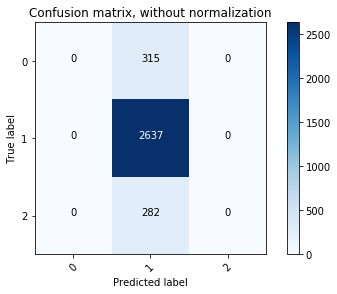

<Figure size 432x288 with 0 Axes>

In [26]:
### CONFUSION MATRIX 
    
y_pred_train = model.predict(X_train_128_FS)
cnf_matrix = confusion_matrix(one_hot(y_train_128_FS, 3).argmax(axis=1), (y_pred_train.round()).argmax(axis=1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(3),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

y_pred_test = model.predict(X_test_128_FS)
cnf_matrix = confusion_matrix(one_hot(y_test_128_FS, 3).argmax(axis=1), (y_pred_test.round()).argmax(axis=1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(3),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(3), normalize=True,
                      title='Normalized confusion matrix')

plt.show()
    

In [ ]:
loss_best = min(history_callback.history['loss'])
accuracy_best = max(history_callback.history['acc'])
precision_best = max(history_callback.history['precision'])
recall_best = max(history_callback.history['recall'])
fmeasure_best = max(history_callback.history['fmeasure'])

In [ ]:
# write in dataframes
parameters = {'net_name':'MobileNet', 'dataset_name':'03_France_ByShape_128_3dim', 
                  'train_or_test':'train', 'image_size':128, 
                  'batch_size_app':-1, 'batch_size_small_net':10, 'dense_1':0.5, 'dense_2':-1,
                  'activation_1':'relu', 'activation_2':'relu', 'optimiser':'adam'}
parameters_df = parameters_df.append(parameters, ignore_index=True)
results = {'net_name':'MobileNet','dataset_name':128, 'train_or_test':'train',
               'loss':loss_best, 'accuracy':accuracy_best, 'precision':precision_best,
               'recall':recall_best, 'fmeasure':fmeasure_best}
results_df = results_df.append(results, ignore_index=True)
    
# evaluate on test
parameters = {'net_name':'MobileNet', 'dataset_name':'03_France_ByShape_128_3dim', 
                  'train_or_test':'test', 'image_size':128, 
                  'batch_size_app':-1, 'batch_size_small_net':10, 'dense_1':0.5 'dense_2':-1,
                  'activation_1':'relu', 'activation_2':'relu', 'optimiser':'adam'}
parameters_df = parameters_df.append(parameters, ignore_index=True)
results = {'net_name':'MobileNet','dataset_name':'03_France_ByShape_128_3dim', 'train_or_test':'test',
               'loss':scores_test[0], 'accuracy':scores_test[1],
               'precision':scores_test[2], 'recall':scores_test[3], 'fmeasure':scores_test[4]}
results_df = results_df.append(results, ignore_index=True)
    
parameters_df.to_csv('./PARAMETERS_AND_RESULTS/11_04_params_France_WITH_RETRAIN.csv', sep='\t')
results_df.to_csv('./PARAMETERS_AND_RESULTS/11_04_results_France_WITH_RETRAIN.csv', sep='\t')

In [27]:
## MobileNet, 160

In [28]:
X_train_shuffled, y_train_shuffled = shuffle_Xy(X_train_160_FS, y_train_160_FS)

In [31]:
model_app = create_net_with_name('MobileNet', X_train_shuffled)
model_app.trainable = True

In [32]:
%%time
model = Sequential()
model.add(model_app)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, fmeasure])
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')
history_callback = model.fit(X_train_shuffled, one_hot(y_train_shuffled, 3),
                                 epochs=200, batch_size=10, callbacks=[callback])

Epoch 1/200
3234/3234 [==============================] - 89s 27ms/step - loss: 2.5149 - acc: 0.8309 - precision: 0.8309 - recall: 0.8309 - fmeasure: 0.8309
Epoch 2/200
3234/3234 [==============================] - 78s 24ms/step - loss: 2.5208 - acc: 0.8383 - precision: 0.8383 - recall: 0.8383 - fmeasure: 0.8383
Epoch 3/200
3234/3234 [==============================] - 77s 24ms/step - loss: 2.9796 - acc: 0.8151 - precision: 0.8151 - recall: 0.8151 - fmeasure: 0.8151
Epoch 4/200
3234/3234 [==============================] - 77s 24ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 5/200
3234/3234 [==============================] - 77s 24ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 6/200
3234/3234 [==============================] - 77s 24ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 7/200
3234/3234 [==============================] - 78s 24m

In [33]:
scores_test = model.evaluate(X_test_160_FS, one_hot(y_test_160_FS, 3))

362/362 [==============================] - 5s 14ms/step


Confusion matrix, without normalization
[[   0  315    0]
 [   0 2637    0]
 [   0  282    0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


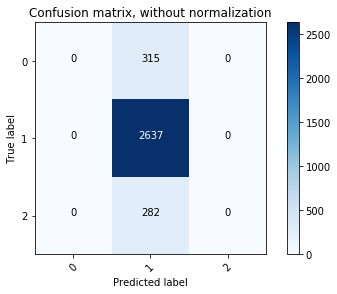

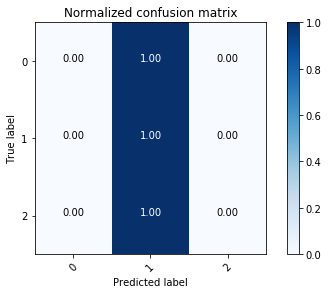

Confusion matrix, without normalization
[[  0  36   0]
 [  0 294   0]
 [  0  32   0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


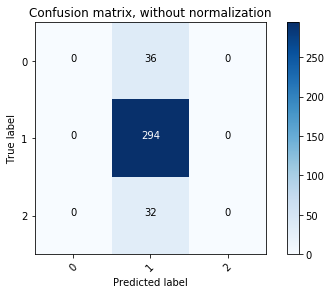

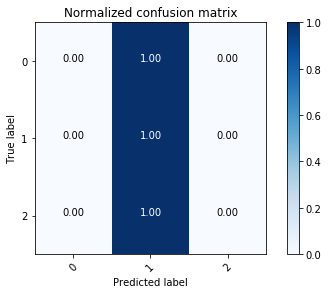

In [34]:
### CONFUSION MATRIX 
    
y_pred_train = model.predict(X_train_160_FS)
cnf_matrix = confusion_matrix(one_hot(y_train_160_FS, 3).argmax(axis=1), (y_pred_train.round()).argmax(axis=1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(3),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(3), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

y_pred_test = model.predict(X_test_160_FS)
cnf_matrix = confusion_matrix(one_hot(y_test_160_FS, 3).argmax(axis=1), (y_pred_test.round()).argmax(axis=1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(3),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(3), normalize=True,
                      title='Normalized confusion matrix')

plt.show()
    

In [36]:
loss_best = min(history_callback.history['loss'])
accuracy_best = max(history_callback.history['acc'])
precision_best = max(history_callback.history['precision'])
recall_best = max(history_callback.history['recall'])
fmeasure_best = max(history_callback.history['fmeasure'])

# write in dataframes
parameters = {'net_name':'MobileNet', 'dataset_name':'03_France_ByShape_160_3dim', 
                  'train_or_test':'train', 'image_size':160, 
                  'batch_size_app':-1, 'batch_size_small_net':10, 'dense_1':0.5, 'dense_2':-1,
                  'activation_1':'relu', 'activation_2':'relu', 'optimiser':'adam'}
parameters_df = parameters_df.append(parameters, ignore_index=True)
results = {'net_name':'MobileNet','dataset_name':160, 'train_or_test':'train',
               'loss':loss_best, 'accuracy':accuracy_best, 'precision':precision_best,
               'recall':recall_best, 'fmeasure':fmeasure_best}
results_df = results_df.append(results, ignore_index=True)
    
# evaluate on test
parameters = {'net_name':'MobileNet', 'dataset_name':'03_France_ByShape_160_3dim', 
                  'train_or_test':'test', 'image_size':160, 
                  'batch_size_app':-1, 'batch_size_small_net':10, 'dense_1':0.5, 'dense_2':-1,
                  'activation_1':'relu', 'activation_2':'relu', 'optimiser':'adam'}
parameters_df = parameters_df.append(parameters, ignore_index=True)
results = {'net_name':'MobileNet','dataset_name':'03_France_ByShape_160_3dim', 'train_or_test':'test',
               'loss':scores_test[0], 'accuracy':scores_test[1],
               'precision':scores_test[2], 'recall':scores_test[3], 'fmeasure':scores_test[4]}
results_df = results_df.append(results, ignore_index=True)
    
parameters_df.to_csv('./PARAMETERS_AND_RESULTS/11_04_params_France_WITH_RETRAIN.csv', sep='\t')
results_df.to_csv('./PARAMETERS_AND_RESULTS/11_04_results_France_WITH_RETRAIN.csv', sep='\t')

In [ ]:
## MobileNet, 192

In [37]:
X_train_shuffled, y_train_shuffled = shuffle_Xy(X_train_192_FS, y_train_192_FS)

In [38]:
model_app = create_net_with_name('MobileNet', X_train_shuffled)
model_app.trainable = True

In [39]:
%%time
model = Sequential()
model.add(model_app)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, fmeasure])
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')
history_callback = model.fit(X_train_shuffled, one_hot(y_train_shuffled, 3),
                                 epochs=200, batch_size=10, callbacks=[callback])

Epoch 1/200
3234/3234 [==============================] - 95s 29ms/step - loss: 2.9696 - acc: 0.8148 - precision: 0.8148 - recall: 0.8148 - fmeasure: 0.8148
Epoch 2/200
3234/3234 [==============================] - 82s 25ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 3/200
3234/3234 [==============================] - 82s 25ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 4/200
3234/3234 [==============================] - 81s 25ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 5/200
3234/3234 [==============================] - 89s 27ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 6/200
3234/3234 [==============================] - 82s 25ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 7/200
3234/3234 [==============================] - 82s 25m

In [40]:
scores_test = model.evaluate(X_test_192_FS, one_hot(y_test_192_FS, 3))

362/362 [==============================] - 5s 13ms/step


Confusion matrix, without normalization
[[   0  315    0]
 [   0 2637    0]
 [   0  282    0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


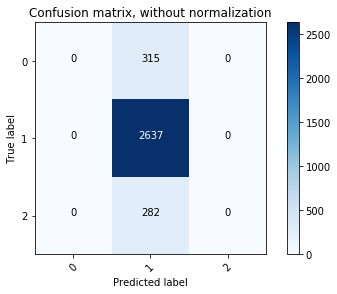

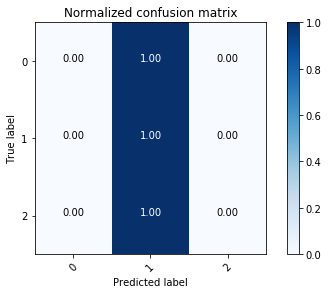

Confusion matrix, without normalization
[[  0  36   0]
 [  0 294   0]
 [  0  32   0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


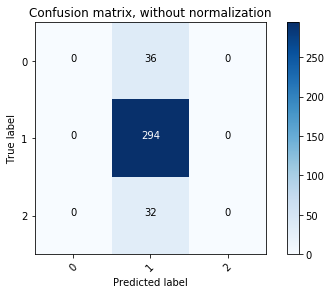

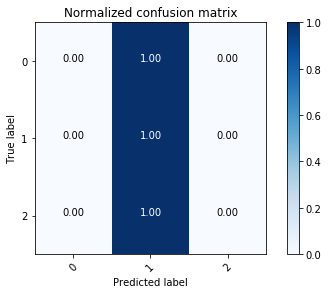

In [41]:
### CONFUSION MATRIX 
    
y_pred_train = model.predict(X_train_192_FS)
cnf_matrix = confusion_matrix(one_hot(y_train_192_FS, 3).argmax(axis=1), (y_pred_train.round()).argmax(axis=1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(3),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(3), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

y_pred_test = model.predict(X_test_192_FS)
cnf_matrix = confusion_matrix(one_hot(y_test_192_FS, 3).argmax(axis=1), (y_pred_test.round()).argmax(axis=1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(3),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(3), normalize=True,
                      title='Normalized confusion matrix')

plt.show()
    

In [43]:
loss_best = min(history_callback.history['loss'])
accuracy_best = max(history_callback.history['acc'])
precision_best = max(history_callback.history['precision'])
recall_best = max(history_callback.history['recall'])
fmeasure_best = max(history_callback.history['fmeasure'])

# write in dataframes
parameters = {'net_name':'MobileNet', 'dataset_name':'03_France_ByShape_192_3dim', 
                  'train_or_test':'train', 'image_size':192, 
                  'batch_size_app':-1, 'batch_size_small_net':10, 'dense_1':0.5, 'dense_2':-1,
                  'activation_1':'relu', 'activation_2':'relu', 'optimiser':'adam'}
parameters_df = parameters_df.append(parameters, ignore_index=True)
results = {'net_name':'MobileNet','dataset_name':'03_France_ByShape_192_3dim', 'train_or_test':'train',
               'loss':loss_best, 'accuracy':accuracy_best, 'precision':precision_best,
               'recall':recall_best, 'fmeasure':fmeasure_best}
results_df = results_df.append(results, ignore_index=True)
    
# evaluate on test
parameters = {'net_name':'MobileNet', 'dataset_name':'03_France_ByShape_192_3dim', 
                  'train_or_test':'test', 'image_size':192, 
                  'batch_size_app':-1, 'batch_size_small_net':10, 'dense_1':0.5, 'dense_2':-1,
                  'activation_1':'relu', 'activation_2':'relu', 'optimiser':'adam'}
parameters_df = parameters_df.append(parameters, ignore_index=True)
results = {'net_name':'MobileNet','dataset_name':'03_France_ByShape_192_3dim', 'train_or_test':'test',
               'loss':scores_test[0], 'accuracy':scores_test[1],
               'precision':scores_test[2], 'recall':scores_test[3], 'fmeasure':scores_test[4]}
results_df = results_df.append(results, ignore_index=True)
    
parameters_df.to_csv('./PARAMETERS_AND_RESULTS/11_04_params_France_WITH_RETRAIN.csv', sep='\t')
results_df.to_csv('./PARAMETERS_AND_RESULTS/11_04_results_France_WITH_RETRAIN.csv', sep='\t')

In [ ]:
## MobileNet, 224

In [44]:
X_train_shuffled, y_train_shuffled = shuffle_Xy(X_train_224_FS, y_train_224_FS)

In [45]:
model_app = create_net_with_name('MobileNet', X_train_shuffled)
model_app.trainable = True

In [46]:
%%time
model = Sequential()
model.add(model_app)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, fmeasure])
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')
history_callback = model.fit(X_train_shuffled, one_hot(y_train_shuffled, 3),
                                 epochs=200, batch_size=10, callbacks=[callback])

Epoch 1/200
3234/3234 [==============================] - 101s 31ms/step - loss: 2.9733 - acc: 0.8139 - precision: 0.8139 - recall: 0.8139 - fmeasure: 0.8139
Epoch 2/200
3234/3234 [==============================] - 88s 27ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 3/200
3234/3234 [==============================] - 88s 27ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 4/200
3234/3234 [==============================] - 88s 27ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 5/200
3234/3234 [==============================] - 88s 27ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 6/200
3234/3234 [==============================] - 88s 27ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 7/200
3234/3234 [==============================] - 88s 27

In [47]:
scores_test = model.evaluate(X_test_224_FS, one_hot(y_test_224_FS, 3))

362/362 [==============================] - 7s 20ms/step


Confusion matrix, without normalization
[[   0  315    0]
 [   0 2637    0]
 [   0  282    0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


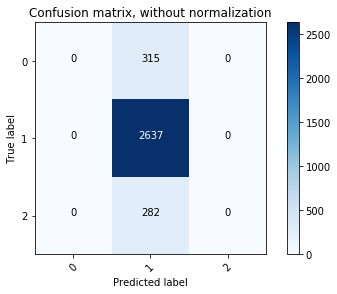

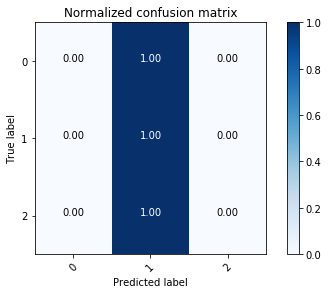

Confusion matrix, without normalization
[[  0  36   0]
 [  0 294   0]
 [  0  32   0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


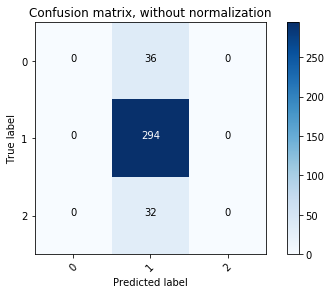

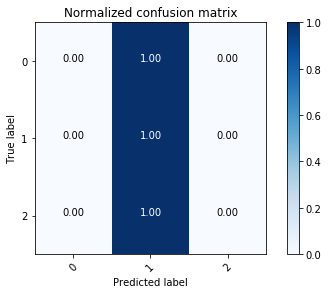

In [48]:
### CONFUSION MATRIX 
    
y_pred_train = model.predict(X_train_224_FS)
cnf_matrix = confusion_matrix(one_hot(y_train_224_FS, 3).argmax(axis=1), (y_pred_train.round()).argmax(axis=1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(3),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(3), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

y_pred_test = model.predict(X_test_224_FS)
cnf_matrix = confusion_matrix(one_hot(y_test_224_FS, 3).argmax(axis=1), (y_pred_test.round()).argmax(axis=1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(3),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(3), normalize=True,
                      title='Normalized confusion matrix')

plt.show()
    

In [50]:
loss_best = min(history_callback.history['loss'])
accuracy_best = max(history_callback.history['acc'])
precision_best = max(history_callback.history['precision'])
recall_best = max(history_callback.history['recall'])
fmeasure_best = max(history_callback.history['fmeasure'])

# write in dataframes
parameters = {'net_name':'MobileNet', 'dataset_name':'03_France_ByShape_224_3dim', 
                  'train_or_test':'train', 'image_size':224, 
                  'batch_size_app':-1, 'batch_size_small_net':10, 'dense_1':0.5, 'dense_2':-1,
                  'activation_1':'relu', 'activation_2':'relu', 'optimiser':'adam'}
parameters_df = parameters_df.append(parameters, ignore_index=True)
results = {'net_name':'MobileNet','dataset_name':'03_France_ByShape_224_3dim', 'train_or_test':'train',
               'loss':loss_best, 'accuracy':accuracy_best, 'precision':precision_best,
               'recall':recall_best, 'fmeasure':fmeasure_best}
results_df = results_df.append(results, ignore_index=True)
    
# evaluate on test
parameters = {'net_name':'MobileNet', 'dataset_name':'03_France_ByShape_224_3dim', 
                  'train_or_test':'test', 'image_size':224, 
                  'batch_size_app':-1, 'batch_size_small_net':10, 'dense_1':0.5, 'dense_2':-1,
                  'activation_1':'relu', 'activation_2':'relu', 'optimiser':'adam'}
parameters_df = parameters_df.append(parameters, ignore_index=True)
results = {'net_name':'MobileNet','dataset_name':'03_France_ByShape_224_3dim', 'train_or_test':'test',
               'loss':scores_test[0], 'accuracy':scores_test[1],
               'precision':scores_test[2], 'recall':scores_test[3], 'fmeasure':scores_test[4]}
results_df = results_df.append(results, ignore_index=True)
    
parameters_df.to_csv('./PARAMETERS_AND_RESULTS/11_04_params_France_WITH_RETRAIN.csv', sep='\t')
results_df.to_csv('./PARAMETERS_AND_RESULTS/11_04_results_France_WITH_RETRAIN.csv', sep='\t')

Epoch 1/200
3234/3234 [==============================] - 50s 15ms/step - loss: 3.0056 - acc: 0.8132 - precision: 0.8132 - recall: 0.8132 - fmeasure: 0.8132
Epoch 2/200
3234/3234 [==============================] - 39s 12ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 3/200
3234/3234 [==============================] - 39s 12ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 4/200
3234/3234 [==============================] - 39s 12ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 5/200
3234/3234 [==============================] - 39s 12ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 6/200
3234/3234 [==============================] - 39s 12ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 7/200
3234/3234 [==============================] - 39s 12m

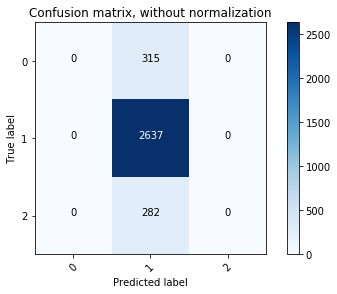

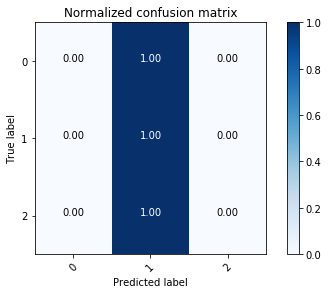

Confusion matrix, without normalization
[[  0  36   0]
 [  0 294   0]
 [  0  32   0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


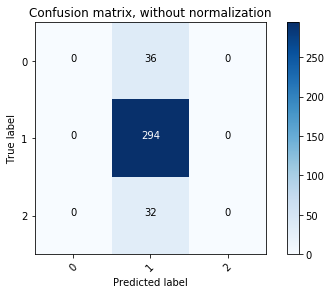

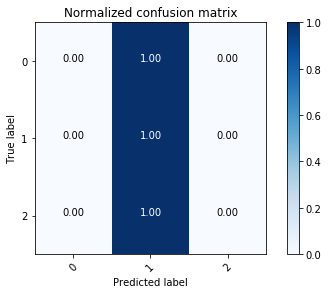

Wall time: 12min 59s


In [52]:
%%time
## SqueezeNet, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_128_3dim',
                                                    image_size=128, X_train=X_train_128_FS, y_train=y_train_128_FS,
                                                    X_test=X_test_128_FS, y_test=y_test_128_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 56s 17ms/step - loss: 2.9767 - acc: 0.8148 - precision: 0.8148 - recall: 0.8148 - fmeasure: 0.8148
Epoch 2/200
3234/3234 [==============================] - 41s 13ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 3/200
3234/3234 [==============================] - 41s 13ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 4/200
3234/3234 [==============================] - 41s 13ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 5/200
3234/3234 [==============================] - 42s 13ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 6/200
3234/3234 [==============================] - 42s 13ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 7/200
3234/3234 [==============================] - 42s 13m

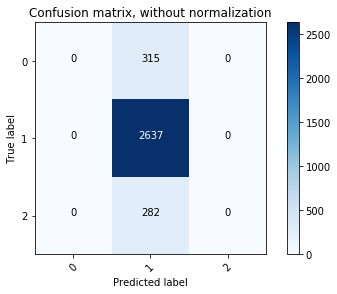

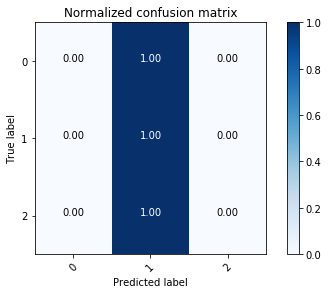

Confusion matrix, without normalization
[[  0  36   0]
 [  0 294   0]
 [  0  32   0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


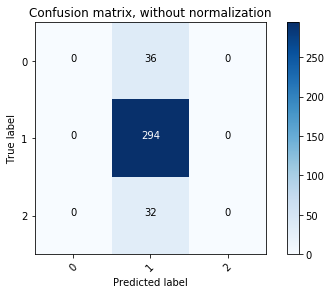

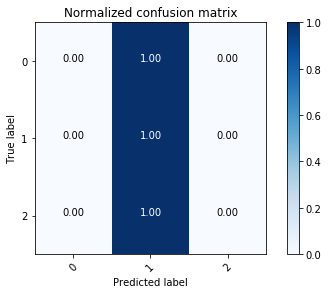

Wall time: 19min 34s


In [53]:
%%time
## SqueezeNet, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_160_3dim',
                                                    image_size=160, X_train=X_train_160_FS, y_train=y_train_160_FS,
                                                    X_test=X_test_160_FS, y_test=y_test_160_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 55s 17ms/step - loss: 3.0082 - acc: 0.8132 - precision: 0.8132 - recall: 0.8132 - fmeasure: 0.8132
Epoch 2/200
3234/3234 [==============================] - 43s 13ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 3/200
3234/3234 [==============================] - 43s 13ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 4/200
3234/3234 [==============================] - 43s 13ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 5/200
3234/3234 [==============================] - 43s 13ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 6/200
3234/3234 [==============================] - 43s 13ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 7/200
3234/3234 [==============================] - 43s 13m

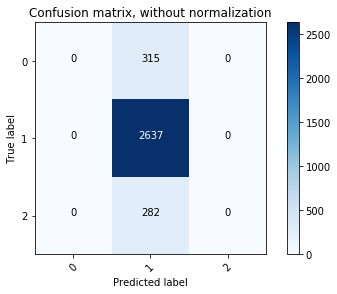

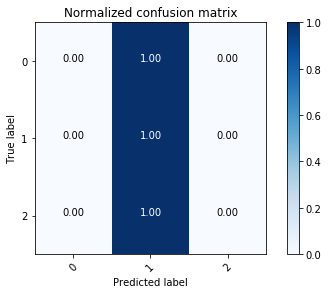

Confusion matrix, without normalization
[[  0  36   0]
 [  0 294   0]
 [  0  32   0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


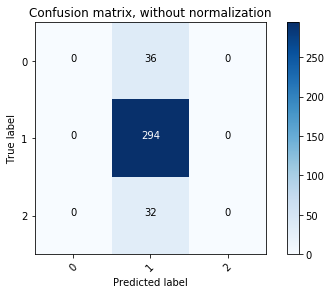

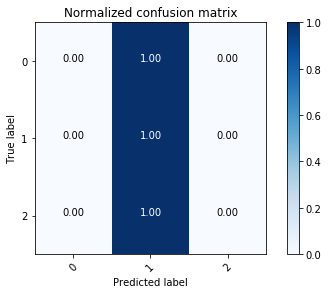

Wall time: 11min 38s


In [54]:
%%time
## SqueezeNet, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_192_3dim',
                                                    image_size=192, X_train=X_train_192_FS, y_train=y_train_192_FS,
                                                    X_test=X_test_192_FS, y_test=y_test_192_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 62s 19ms/step - loss: 2.9989 - acc: 0.8132 - precision: 0.8132 - recall: 0.8132 - fmeasure: 0.8132
Epoch 2/200
3234/3234 [==============================] - 46s 14ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 3/200
3234/3234 [==============================] - 46s 14ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 4/200
3234/3234 [==============================] - 47s 14ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 5/200
3234/3234 [==============================] - 47s 15ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 6/200
3234/3234 [==============================] - 47s 15ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 7/200
3234/3234 [==============================] - 47s 14m

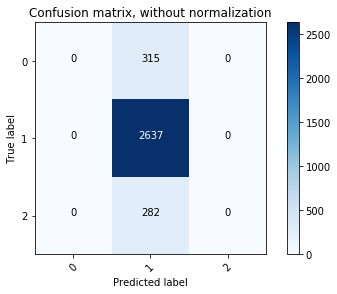

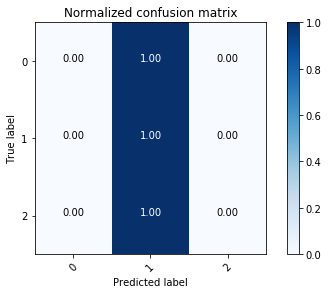

Confusion matrix, without normalization
[[  0  36   0]
 [  0 294   0]
 [  0  32   0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


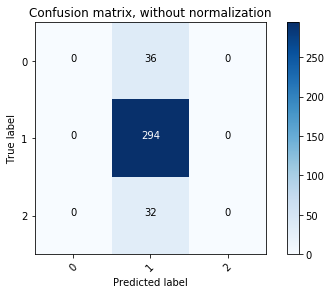

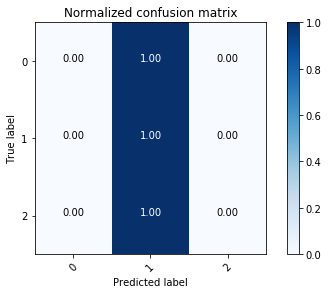

Wall time: 18min 56s


In [55]:
%%time
## SqueezeNet, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_224_3dim',
                                                    image_size=224, X_train=X_train_224_FS, y_train=y_train_224_FS,
                                                    X_test=X_test_224_FS, y_test=y_test_224_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 151s 47ms/step - loss: 0.6818 - acc: 0.8176 - precision: 0.9148 - recall: 0.7010 - fmeasure: 0.7865
Epoch 2/200
3234/3234 [==============================] - 130s 40ms/step - loss: 0.4596 - acc: 0.8862 - precision: 0.9318 - recall: 0.8491 - fmeasure: 0.8863
Epoch 3/200
3234/3234 [==============================] - 130s 40ms/step - loss: 0.3267 - acc: 0.9298 - precision: 0.9409 - recall: 0.9177 - fmeasure: 0.9286
Epoch 4/200
3234/3234 [==============================] - 130s 40ms/step - loss: 0.2561 - acc: 0.9477 - precision: 0.9534 - recall: 0.9406 - fmeasure: 0.9466
Epoch 5/200
3234/3234 [==============================] - 130s 40ms/step - loss: 0.2382 - acc: 0.9437 - precision: 0.9482 - recall: 0.9385 - fmeasure: 0.9431
Epoch 6/200
3234/3234 [==============================] - 129s 40ms/step - loss: 0.3848 - acc: 0.9388 - precision: 0.9427 - recall: 0.9354 - fmeasure: 0.9389
Epoch 7/200
3234/3234 [==============================] - 1

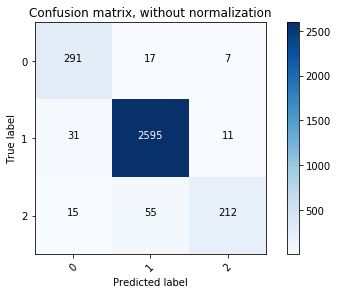

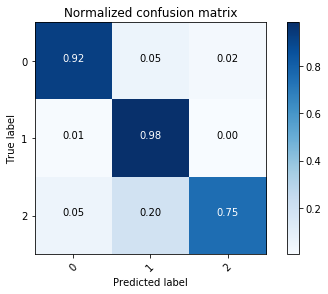

Confusion matrix, without normalization
[[ 26  10   0]
 [  9 284   1]
 [  3   9  20]]
Normalized confusion matrix
[[0.72222222 0.27777778 0.        ]
 [0.03061224 0.96598639 0.00340136]
 [0.09375    0.28125    0.625     ]]


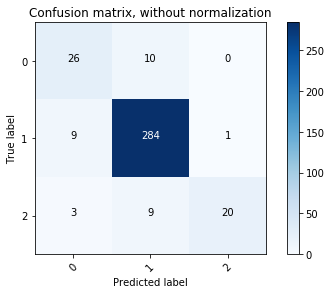

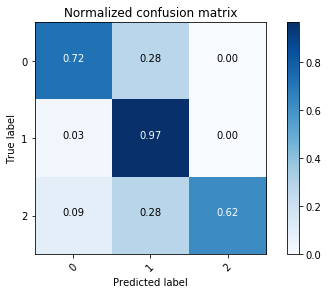

Wall time: 34min 30s


In [56]:
%%time
## Xception, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_128_3dim',
                                                    image_size=128, X_train=X_train_128_FS, y_train=y_train_128_FS,
                                                    X_test=X_test_128_FS, y_test=y_test_128_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 154s 48ms/step - loss: 0.5020 - acc: 0.8581 - precision: 0.9072 - recall: 0.7706 - fmeasure: 0.8245
Epoch 2/200
3234/3234 [==============================] - 129s 40ms/step - loss: 0.3180 - acc: 0.9097 - precision: 0.9260 - recall: 0.8865 - fmeasure: 0.9045
Epoch 3/200
3234/3234 [==============================] - 130s 40ms/step - loss: 0.2027 - acc: 0.9378 - precision: 0.9497 - recall: 0.9310 - fmeasure: 0.9397
Epoch 4/200
3234/3234 [==============================] - 129s 40ms/step - loss: 0.2613 - acc: 0.9409 - precision: 0.9486 - recall: 0.9304 - fmeasure: 0.9389
Epoch 5/200
3234/3234 [==============================] - 130s 40ms/step - loss: 0.1904 - acc: 0.9443 - precision: 0.9538 - recall: 0.9357 - fmeasure: 0.9441
Epoch 6/200
3234/3234 [==============================] - 129s 40ms/step - loss: 0.1139 - acc: 0.9657 - precision: 0.9700 - recall: 0.9617 - fmeasure: 0.9655
Epoch 7/200
3234/3234 [==============================] - 1

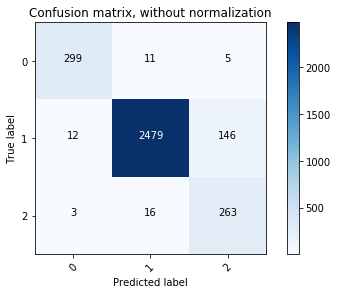

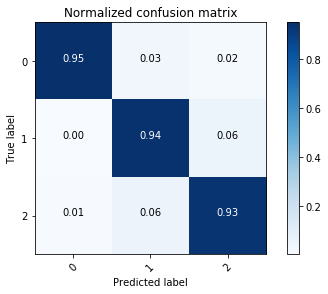

Confusion matrix, without normalization
[[ 28   7   1]
 [  5 276  13]
 [  0   3  29]]
Normalized confusion matrix
[[0.77777778 0.19444444 0.02777778]
 [0.0170068  0.93877551 0.04421769]
 [0.         0.09375    0.90625   ]]


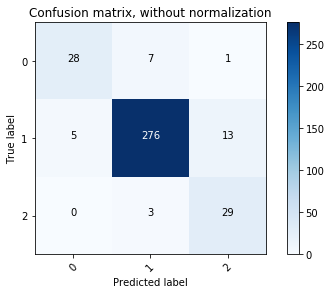

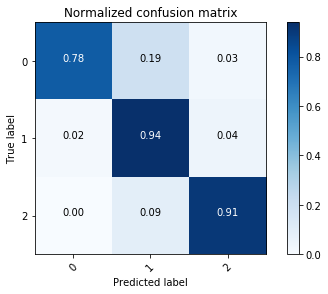

Wall time: 38min 42s


In [57]:
%%time
## Xception, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_128_3dim',
                                                    image_size=128, X_train=X_train_128_FS, y_train=y_train_128_FS,
                                                    X_test=X_test_128_FS, y_test=y_test_128_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 157s 49ms/step - loss: 0.4440 - acc: 0.8769 - precision: 0.9189 - recall: 0.7996 - fmeasure: 0.8498
Epoch 2/200
3234/3234 [==============================] - 136s 42ms/step - loss: 0.2623 - acc: 0.9261 - precision: 0.9426 - recall: 0.8998 - fmeasure: 0.9193
Epoch 3/200
3234/3234 [==============================] - 136s 42ms/step - loss: 0.1498 - acc: 0.9583 - precision: 0.9623 - recall: 0.9521 - fmeasure: 0.9568
Epoch 4/200
3234/3234 [==============================] - 135s 42ms/step - loss: 0.2925 - acc: 0.9431 - precision: 0.9500 - recall: 0.9335 - fmeasure: 0.9412
Epoch 5/200
3234/3234 [==============================] - 135s 42ms/step - loss: 0.5492 - acc: 0.8862 - precision: 0.8984 - recall: 0.8689 - fmeasure: 0.8823
Epoch 6/200
3234/3234 [==============================] - 136s 42ms/step - loss: 0.3533 - acc: 0.9119 - precision: 0.9214 - recall: 0.9041 - fmeasure: 0.9122
Epoch 7/200
3234/3234 [==============================] - 1

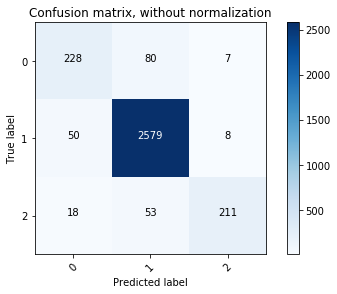

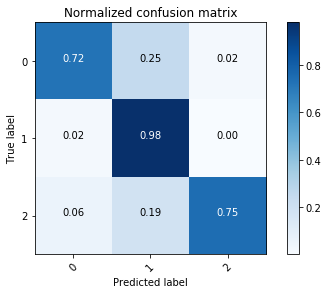

Confusion matrix, without normalization
[[ 26   9   1]
 [  5 286   3]
 [  5   5  22]]
Normalized confusion matrix
[[0.72222222 0.25       0.02777778]
 [0.0170068  0.97278912 0.01020408]
 [0.15625    0.15625    0.6875    ]]


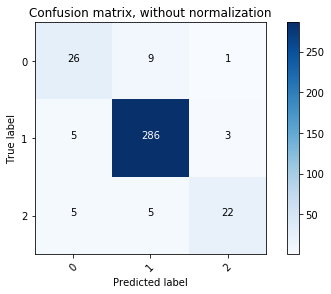

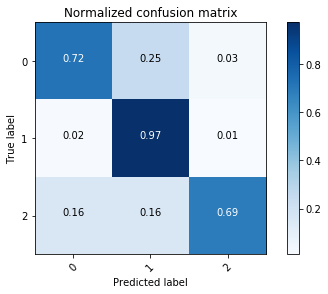

Wall time: 54min 9s


In [58]:
%%time
## Xception, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_160_3dim',
                                                    image_size=160, X_train=X_train_160_FS, y_train=y_train_160_FS,
                                                    X_test=X_test_160_FS, y_test=y_test_160_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 162s 50ms/step - loss: 0.4982 - acc: 0.8782 - precision: 0.8783 - recall: 0.7984 - fmeasure: 0.8299
Epoch 2/200
3234/3234 [==============================] - 136s 42ms/step - loss: 0.4915 - acc: 0.8893 - precision: 0.9042 - recall: 0.8695 - fmeasure: 0.8852
Epoch 3/200
3234/3234 [==============================] - 136s 42ms/step - loss: 0.2933 - acc: 0.9326 - precision: 0.9399 - recall: 0.9202 - fmeasure: 0.9294
Epoch 4/200
3234/3234 [==============================] - 136s 42ms/step - loss: 0.4806 - acc: 0.9267 - precision: 0.9336 - recall: 0.9184 - fmeasure: 0.9255
Epoch 5/200
3234/3234 [==============================] - 136s 42ms/step - loss: 0.4711 - acc: 0.9246 - precision: 0.9305 - recall: 0.9156 - fmeasure: 0.9225
Epoch 6/200
3234/3234 [==============================] - 136s 42ms/step - loss: 0.3795 - acc: 0.9301 - precision: 0.9385 - recall: 0.9249 - fmeasure: 0.9312
Epoch 7/200
3234/3234 [==============================] - 1

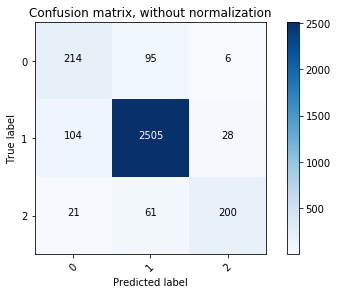

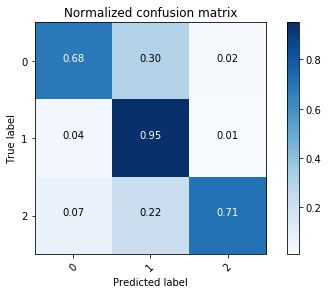

Confusion matrix, without normalization
[[ 19  16   1]
 [ 16 273   5]
 [  5  15  12]]
Normalized confusion matrix
[[0.52777778 0.44444444 0.02777778]
 [0.05442177 0.92857143 0.0170068 ]
 [0.15625    0.46875    0.375     ]]


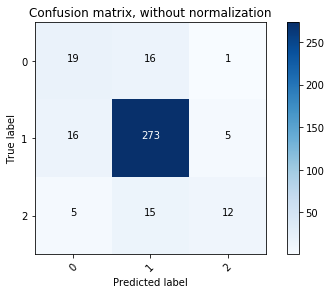

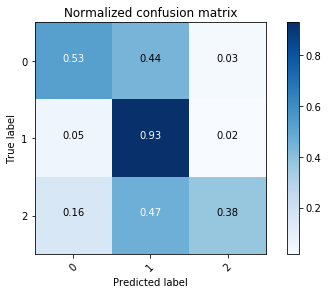

Wall time: 31min 43s


In [59]:
%%time
## Xception, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_160_3dim',
                                                    image_size=160, X_train=X_train_160_FS, y_train=y_train_160_FS,
                                                    X_test=X_test_160_FS, y_test=y_test_160_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 169s 52ms/step - loss: 0.4961 - acc: 0.8853 - precision: 0.8987 - recall: 0.8306 - fmeasure: 0.8581
Epoch 2/200
3234/3234 [==============================] - 135s 42ms/step - loss: 0.3752 - acc: 0.9048 - precision: 0.9171 - recall: 0.8840 - fmeasure: 0.8988
Epoch 3/200
3234/3234 [==============================] - 135s 42ms/step - loss: 0.2725 - acc: 0.9378 - precision: 0.9460 - recall: 0.9292 - fmeasure: 0.9371
Epoch 4/200
3234/3234 [==============================] - 135s 42ms/step - loss: 0.1494 - acc: 0.9567 - precision: 0.9593 - recall: 0.9536 - fmeasure: 0.9563
Epoch 5/200
3234/3234 [==============================] - 136s 42ms/step - loss: 0.1289 - acc: 0.9654 - precision: 0.9671 - recall: 0.9604 - fmeasure: 0.9635
Epoch 6/200
3234/3234 [==============================] - 136s 42ms/step - loss: 0.1940 - acc: 0.9542 - precision: 0.9584 - recall: 0.9518 - fmeasure: 0.9549
Epoch 7/200
3234/3234 [==============================] - 1

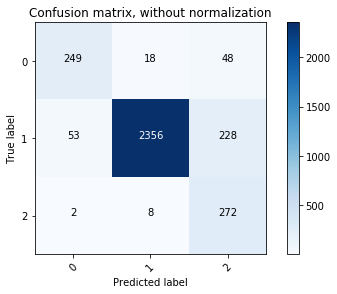

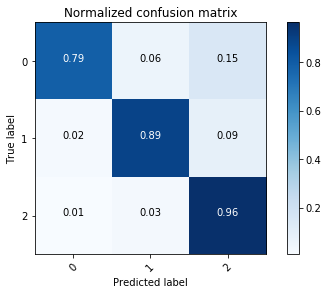

Confusion matrix, without normalization
[[ 22   8   6]
 [  6 264  24]
 [  0   2  30]]
Normalized confusion matrix
[[0.61111111 0.22222222 0.16666667]
 [0.02040816 0.89795918 0.08163265]
 [0.         0.0625     0.9375    ]]


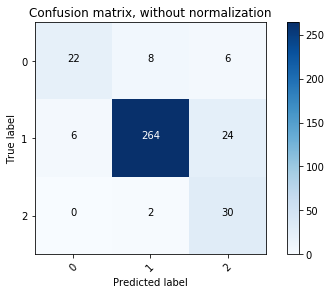

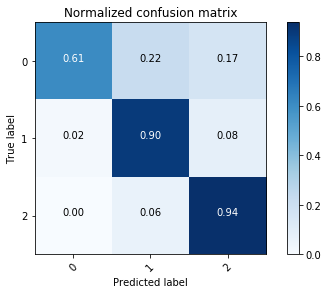

Wall time: 59min 49s


In [60]:
%%time
## Xception, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_192_3dim',
                                                    image_size=192, X_train=X_train_192_FS, y_train=y_train_192_FS,
                                                    X_test=X_test_192_FS, y_test=y_test_192_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 173s 54ms/step - loss: 0.5114 - acc: 0.8129 - precision: 0.9542 - recall: 0.6945 - fmeasure: 0.7967
Epoch 2/200
3234/3234 [==============================] - 144s 44ms/step - loss: 0.2954 - acc: 0.9045 - precision: 0.9510 - recall: 0.8581 - fmeasure: 0.8988
Epoch 3/200
3234/3234 [==============================] - 143s 44ms/step - loss: 0.2261 - acc: 0.9357 - precision: 0.9465 - recall: 0.9218 - fmeasure: 0.9331
Epoch 4/200
3234/3234 [==============================] - 144s 44ms/step - loss: 0.1514 - acc: 0.9623 - precision: 0.9655 - recall: 0.9586 - fmeasure: 0.9618
Epoch 5/200
3234/3234 [==============================] - 143s 44ms/step - loss: 0.1877 - acc: 0.9496 - precision: 0.9567 - recall: 0.9437 - fmeasure: 0.9497
Epoch 6/200
3234/3234 [==============================] - 143s 44ms/step - loss: 0.1096 - acc: 0.9675 - precision: 0.9714 - recall: 0.9641 - fmeasure: 0.9676
Epoch 7/200
3234/3234 [==============================] - 1

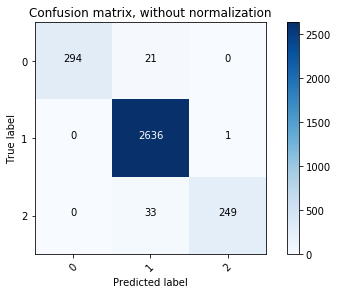

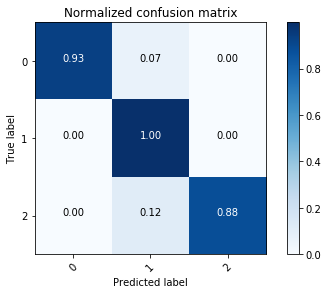

Confusion matrix, without normalization
[[ 30   6   0]
 [  0 293   1]
 [  0  11  21]]
Normalized confusion matrix
[[0.83333333 0.16666667 0.        ]
 [0.         0.99659864 0.00340136]
 [0.         0.34375    0.65625   ]]


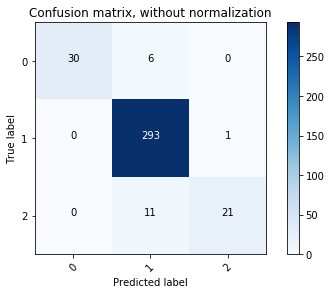

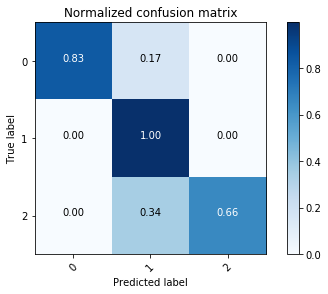

Wall time: 1h 14min 49s


In [61]:
%%time
## Xception, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_224_3dim',
                                                    image_size=224, X_train=X_train_224_FS, y_train=y_train_224_FS,
                                                    X_test=X_test_224_FS, y_test=y_test_224_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 73s 22ms/step - loss: 3.0014 - acc: 0.8132 - precision: 0.8132 - recall: 0.8132 - fmeasure: 0.8132
Epoch 2/200
3234/3234 [==============================] - 47s 15ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 3/200
3234/3234 [==============================] - 47s 15ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 4/200
3234/3234 [==============================] - 48s 15ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 5/200
3234/3234 [==============================] - 48s 15ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 6/200
3234/3234 [==============================] - 48s 15ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 7/200
3234/3234 [==============================] - 47s 15m

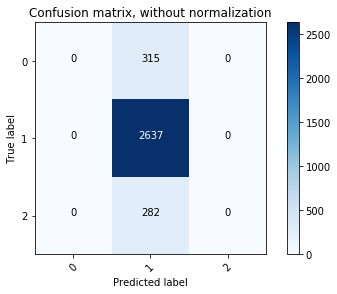

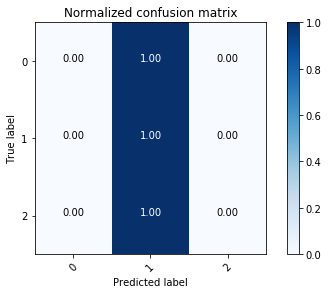

Confusion matrix, without normalization
[[  0  36   0]
 [  0 294   0]
 [  0  32   0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


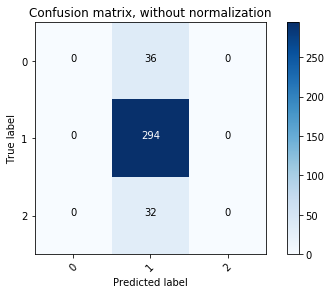

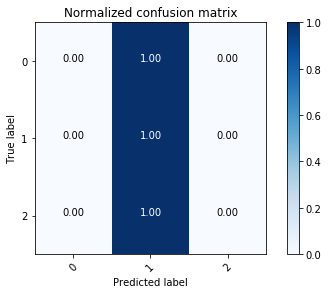

Wall time: 11min 42s


In [62]:
%%time
## VGG16, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_128_3dim',
                                                    image_size=128, X_train=X_train_128_FS, y_train=y_train_128_FS,
                                                    X_test=X_test_128_FS, y_test=y_test_128_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 88s 27ms/step - loss: 3.0109 - acc: 0.8123 - precision: 0.8123 - recall: 0.8123 - fmeasure: 0.8123
Epoch 2/200
3234/3234 [==============================] - 61s 19ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 3/200
3234/3234 [==============================] - 61s 19ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 4/200
3234/3234 [==============================] - 61s 19ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 5/200
3234/3234 [==============================] - 61s 19ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 6/200
3234/3234 [==============================] - 61s 19ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 7/200
3234/3234 [==============================] - 62s 19m

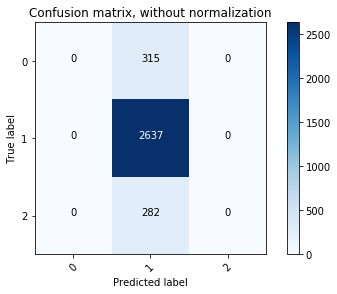

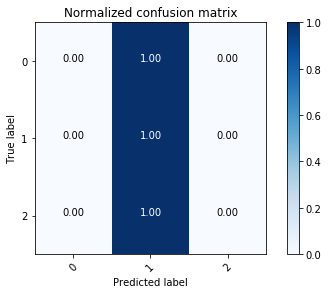

Confusion matrix, without normalization
[[  0  36   0]
 [  0 294   0]
 [  0  32   0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


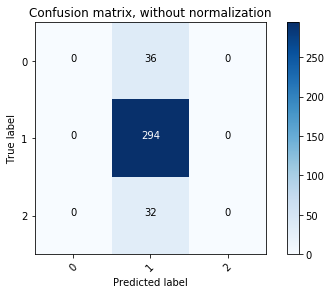

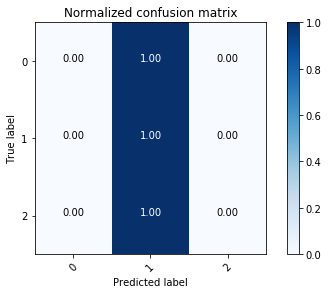

Wall time: 14min 3s


In [63]:
%%time
## VGG16, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_160_3dim',
                                                    image_size=160, X_train=X_train_160_FS, y_train=y_train_160_FS,
                                                    X_test=X_test_160_FS, y_test=y_test_160_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 101s 31ms/step - loss: 2.9958 - acc: 0.8132 - precision: 0.8132 - recall: 0.8132 - fmeasure: 0.8132
Epoch 2/200
3234/3234 [==============================] - 74s 23ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 3/200
3234/3234 [==============================] - 74s 23ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 4/200
3234/3234 [==============================] - 74s 23ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 5/200
3234/3234 [==============================] - 74s 23ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 6/200
3234/3234 [==============================] - 75s 23ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 7/200
3234/3234 [==============================] - 75s 23

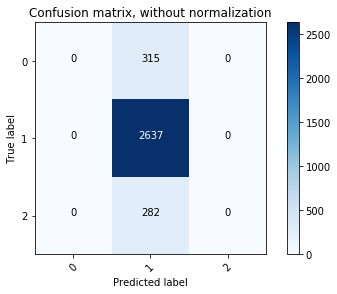

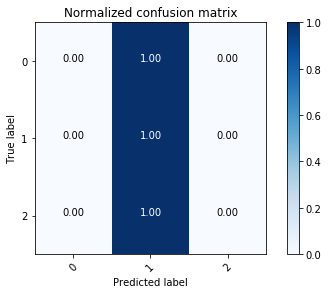

Confusion matrix, without normalization
[[  0  36   0]
 [  0 294   0]
 [  0  32   0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


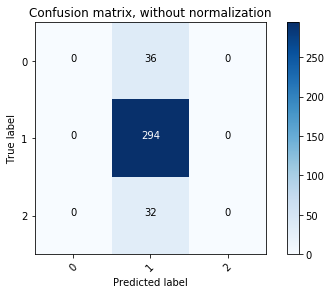

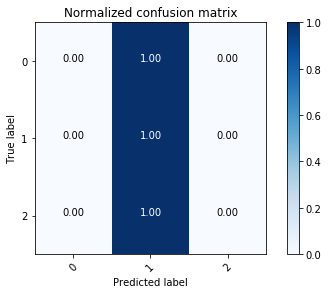

Wall time: 19min 5s


In [64]:
%%time
## VGG16, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_192_3dim',
                                                    image_size=192, X_train=X_train_192_FS, y_train=y_train_192_FS,
                                                    X_test=X_test_192_FS, y_test=y_test_192_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 121s 37ms/step - loss: 3.0273 - acc: 0.8117 - precision: 0.8114 - recall: 0.8114 - fmeasure: 0.8114
Epoch 2/200
3234/3234 [==============================] - 93s 29ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 3/200
3234/3234 [==============================] - 93s 29ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 4/200
3234/3234 [==============================] - 93s 29ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 5/200
3234/3234 [==============================] - 93s 29ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 6/200
3234/3234 [==============================] - 94s 29ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 7/200
3234/3234 [==============================] - 94s 29

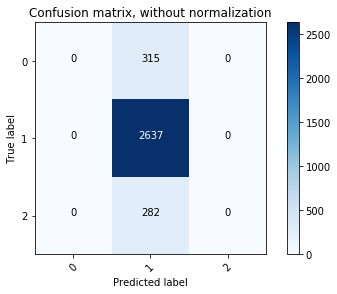

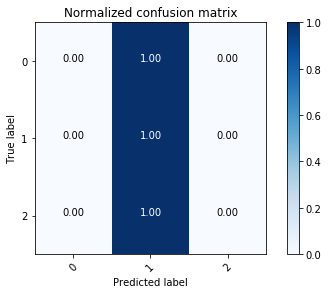

Confusion matrix, without normalization
[[  0  36   0]
 [  0 294   0]
 [  0  32   0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


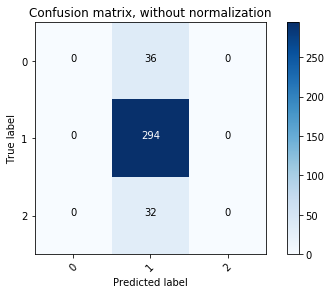

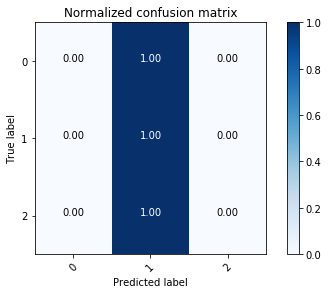

Wall time: 29min 53s


In [65]:
%%time
## VGG16, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_224_3dim',
                                                    image_size=224, X_train=X_train_224_FS, y_train=y_train_224_FS,
                                                    X_test=X_test_224_FS, y_test=y_test_224_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 83s 26ms/step - loss: 2.9844 - acc: 0.8145 - precision: 0.8145 - recall: 0.8145 - fmeasure: 0.8145
Epoch 2/200
3234/3234 [==============================] - 55s 17ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 3/200
3234/3234 [==============================] - 55s 17ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 4/200
3234/3234 [==============================] - 54s 17ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 5/200
3234/3234 [==============================] - 54s 17ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 6/200
3234/3234 [==============================] - 54s 17ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 7/200
3234/3234 [==============================] - 54s 17m

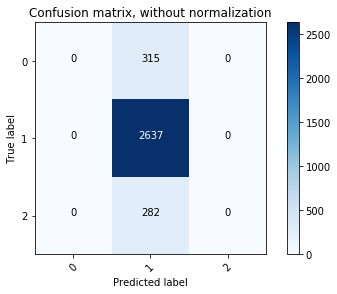

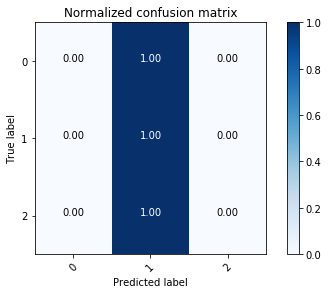

Confusion matrix, without normalization
[[  0  36   0]
 [  0 294   0]
 [  0  32   0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


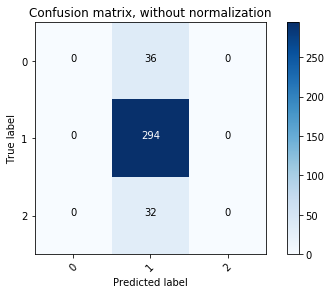

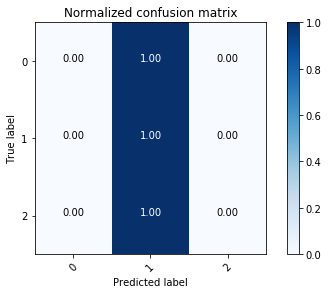

Wall time: 12min 30s


In [66]:
%%time
## VGG19, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_128_3dim',
                                                    image_size=128, X_train=X_train_128_FS, y_train=y_train_128_FS,
                                                    X_test=X_test_128_FS, y_test=y_test_128_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 100s 31ms/step - loss: 2.9799 - acc: 0.8145 - precision: 0.8145 - recall: 0.8145 - fmeasure: 0.8145
Epoch 2/200
3234/3234 [==============================] - 73s 22ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 3/200
3234/3234 [==============================] - 73s 22ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 4/200
3234/3234 [==============================] - 73s 22ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 5/200
3234/3234 [==============================] - 73s 22ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 6/200
3234/3234 [==============================] - 73s 22ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 7/200
3234/3234 [==============================] - 73s 22

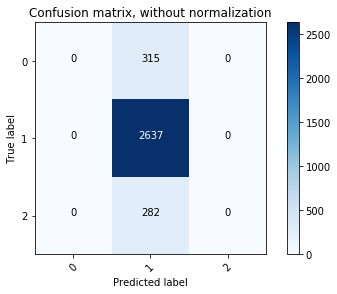

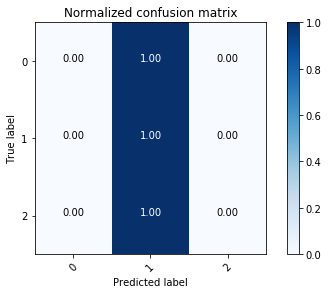

Confusion matrix, without normalization
[[  0  36   0]
 [  0 294   0]
 [  0  32   0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


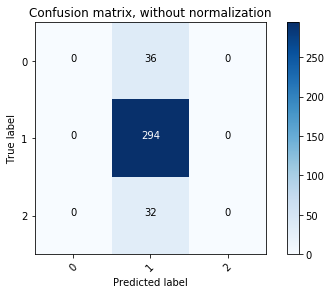

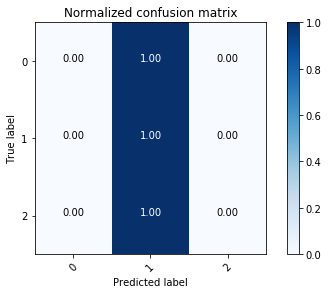

Wall time: 16min 16s


In [68]:
%%time
## VGG19, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_160_3dim',
                                                    image_size=160, X_train=X_train_160_FS, y_train=y_train_160_FS,
                                                    X_test=X_test_160_FS, y_test=y_test_160_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 114s 35ms/step - loss: 2.9858 - acc: 0.8145 - precision: 0.8145 - recall: 0.8145 - fmeasure: 0.8145
Epoch 2/200
3234/3234 [==============================] - 88s 27ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 3/200
3234/3234 [==============================] - 88s 27ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 4/200
3234/3234 [==============================] - 89s 27ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 5/200
3234/3234 [==============================] - 88s 27ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 6/200
3234/3234 [==============================] - 88s 27ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 7/200
3234/3234 [==============================] - 88s 27

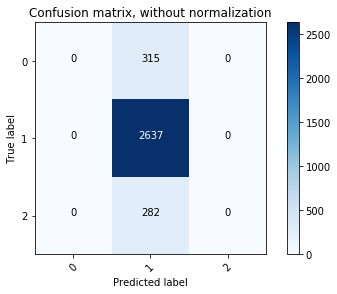

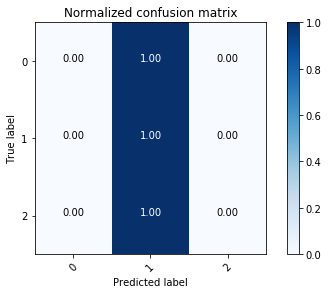

Confusion matrix, without normalization
[[  0  36   0]
 [  0 294   0]
 [  0  32   0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


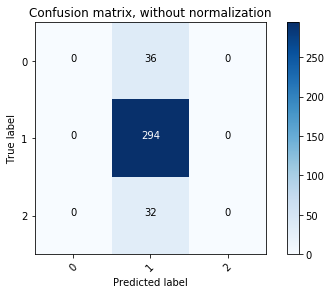

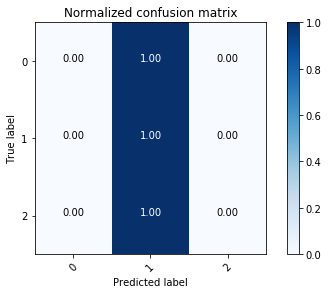

Wall time: 20min 55s


In [69]:
%%time
## VGG19, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_192_3dim',
                                                    image_size=192, X_train=X_train_192_FS, y_train=y_train_192_FS,
                                                    X_test=X_test_192_FS, y_test=y_test_192_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 136s 42ms/step - loss: 2.9979 - acc: 0.8135 - precision: 0.8135 - recall: 0.8135 - fmeasure: 0.8135
Epoch 2/200
3234/3234 [==============================] - 110s 34ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 3/200
3234/3234 [==============================] - 110s 34ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 4/200
3234/3234 [==============================] - 110s 34ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 5/200
3234/3234 [==============================] - 110s 34ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 6/200
3234/3234 [==============================] - 110s 34ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 7/200
3234/3234 [==============================] - 1

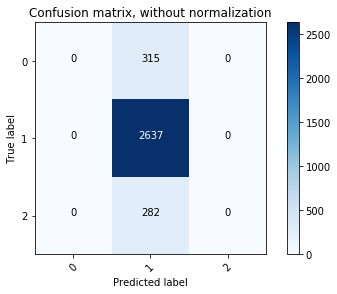

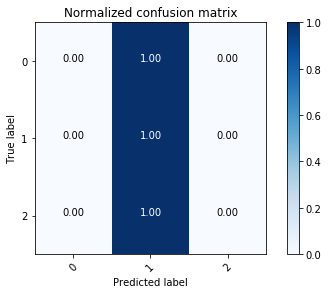

Confusion matrix, without normalization
[[  0  36   0]
 [  0 294   0]
 [  0  32   0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


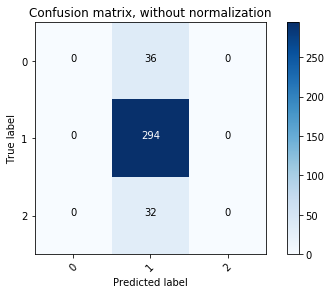

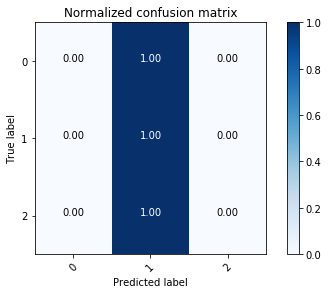

Wall time: 33min 6s


In [70]:
%%time
## VGG19, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_224_3dim',
                                                    image_size=224, X_train=X_train_224_FS, y_train=y_train_224_FS,
                                                    X_test=X_test_224_FS, y_test=y_test_224_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

In [10]:
%%time
# Now load another dataset

X_128_F_ByMeaning, y_128_F_ByMeaning = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByMeaning_128_3dim",
                                            ["GazolineStation", "Hotel", "Parking", "Restaurant",
                                             "Taxi", "TollRoad", "Transport"],
                                            already_transformed=True)   

X_160_F_ByMeaning, y_160_F_ByMeaning = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByMeaning_160_3dim",
                                            ["GazolineStation", "Hotel", "Parking", "Restaurant",
                                             "Taxi", "TollRoad", "Transport"],
                                            already_transformed=True)   

X_192_F_ByMeaning, y_192_F_ByMeaning = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByMeaning_192_3dim",
                                            ["GazolineStation", "Hotel", "Parking", "Restaurant",
                                             "Taxi", "TollRoad", "Transport"],
                                            already_transformed=True)   

X_224_F_ByMeaning, y_224_F_ByMeaning = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByMeaning_224_3dim",
                                            ["GazolineStation", "Hotel", "Parking", "Restaurant",
                                             "Taxi", "TollRoad", "Transport"],
                                            already_transformed=True)   

#Than divide all of them to train and test

X_train_128_FM, y_train_128_FM, X_test_128_FM, y_test_128_FM = divide_to_train_end_test(X_128_F_ByMeaning,
                                                                                        y_128_F_ByMeaning, num_categories=7)
X_train_160_FM, y_train_160_FM, X_test_160_FM, y_test_160_FM = divide_to_train_end_test(X_160_F_ByMeaning,
                                                                                        y_160_F_ByMeaning, num_categories=7)
X_train_192_FM, y_train_192_FM, X_test_192_FM, y_test_192_FM = divide_to_train_end_test(X_192_F_ByMeaning,
                                                                                        y_192_F_ByMeaning, num_categories=7)
X_train_224_FM, y_train_224_FM, X_test_224_FM, y_test_224_FM = divide_to_train_end_test(X_224_F_ByMeaning,
                                                                                        y_224_F_ByMeaning, num_categories=7)



Wall time: 26.9 s


Epoch 1/200
3123/3123 [==============================] - 112s 36ms/step - loss: 4.9000 - acc: 0.5328 - precision: 0.5594 - recall: 0.5178 - fmeasure: 0.5340
Epoch 2/200
3123/3123 [==============================] - 77s 25ms/step - loss: 2.6550 - acc: 0.5594 - precision: 0.6377 - recall: 0.4691 - fmeasure: 0.5345
Epoch 3/200
3123/3123 [==============================] - 77s 25ms/step - loss: 2.3774 - acc: 0.5991 - precision: 0.6852 - recall: 0.5139 - fmeasure: 0.5825
Epoch 4/200
3123/3123 [==============================] - 77s 25ms/step - loss: 2.1242 - acc: 0.6254 - precision: 0.7146 - recall: 0.5322 - fmeasure: 0.6051
Epoch 5/200
3123/3123 [==============================] - 77s 25ms/step - loss: 2.0179 - acc: 0.6052 - precision: 0.6996 - recall: 0.4922 - fmeasure: 0.5706
Epoch 6/200
3123/3123 [==============================] - 77s 25ms/step - loss: 1.5072 - acc: 0.6250 - precision: 0.7579 - recall: 0.5120 - fmeasure: 0.6046
Epoch 7/200
3123/3123 [==============================] - 77s 25

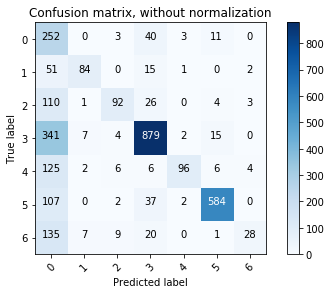

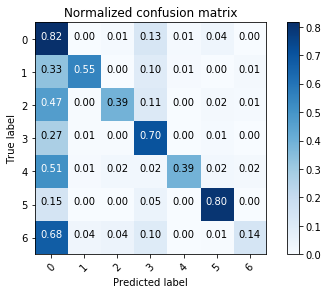

Confusion matrix, without normalization
[[28  0  0  6  0  1  0]
 [ 7  8  1  2  0  0  0]
 [ 9  2 13  2  0  1  0]
 [37  0  0 93  3  6  0]
 [21  0  1  0  2  4  0]
 [18  0  2  6  0 56  0]
 [15  0  1  1  0  0  6]]
Normalized confusion matrix
[[0.8        0.         0.         0.17142857 0.         0.02857143
  0.        ]
 [0.38888889 0.44444444 0.05555556 0.11111111 0.         0.
  0.        ]
 [0.33333333 0.07407407 0.48148148 0.07407407 0.         0.03703704
  0.        ]
 [0.26618705 0.         0.         0.66906475 0.02158273 0.04316547
  0.        ]
 [0.75       0.         0.03571429 0.         0.07142857 0.14285714
  0.        ]
 [0.2195122  0.         0.02439024 0.07317073 0.         0.68292683
  0.        ]
 [0.65217391 0.         0.04347826 0.04347826 0.         0.
  0.26086957]]


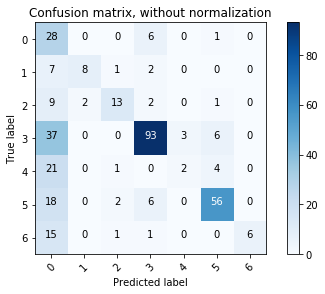

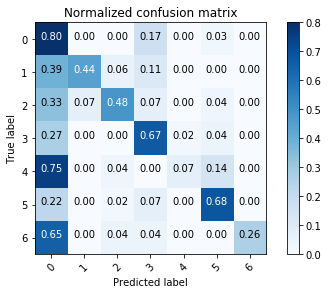

Wall time: 28min 20s


In [72]:
%%time
## MobileNet, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_128_3dim',
                                                    image_size=128, X_train=X_train_128_FM, y_train=y_train_128_FM,
                                                    X_test=X_test_128_FM, y_test=y_test_128_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 112s 36ms/step - loss: 7.4809 - acc: 0.4918 - precision: 0.4921 - recall: 0.4918 - fmeasure: 0.4920
Epoch 2/200
3123/3123 [==============================] - 80s 26ms/step - loss: 7.6426 - acc: 0.5191 - precision: 0.5191 - recall: 0.5191 - fmeasure: 0.5191
Epoch 3/200
3123/3123 [==============================] - 79s 25ms/step - loss: 7.2436 - acc: 0.5411 - precision: 0.5413 - recall: 0.5411 - fmeasure: 0.5412
Epoch 4/200
3123/3123 [==============================] - 79s 25ms/step - loss: 3.7839 - acc: 0.5498 - precision: 0.6534 - recall: 0.4845 - fmeasure: 0.5493
Epoch 5/200
3123/3123 [==============================] - 79s 25ms/step - loss: 2.6714 - acc: 0.5604 - precision: 0.6866 - recall: 0.4425 - fmeasure: 0.5312
Epoch 6/200
3123/3123 [==============================] - 80s 26ms/step - loss: 3.2823 - acc: 0.5062 - precision: 0.5985 - recall: 0.4134 - fmeasure: 0.4833
Epoch 7/200
3123/3123 [==============================] - 80s 26

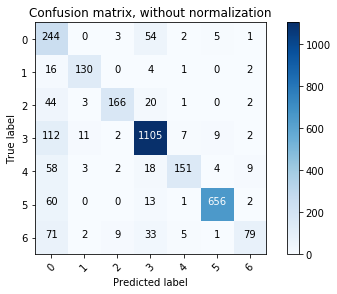

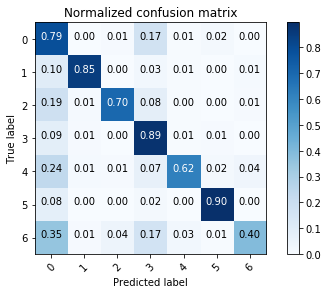

Confusion matrix, without normalization
[[ 21   0   3  10   0   1   0]
 [  3  12   0   1   2   0   0]
 [  9   1  12   2   0   0   3]
 [ 24   1   0 108   2   2   2]
 [ 15   0   0   5   5   3   0]
 [  7   0   0   3   0  71   1]
 [ 12   1   0   1   0   0   9]]
Normalized confusion matrix
[[0.6        0.         0.08571429 0.28571429 0.         0.02857143
  0.        ]
 [0.16666667 0.66666667 0.         0.05555556 0.11111111 0.
  0.        ]
 [0.33333333 0.03703704 0.44444444 0.07407407 0.         0.
  0.11111111]
 [0.17266187 0.00719424 0.         0.77697842 0.01438849 0.01438849
  0.01438849]
 [0.53571429 0.         0.         0.17857143 0.17857143 0.10714286
  0.        ]
 [0.08536585 0.         0.         0.03658537 0.         0.86585366
  0.01219512]
 [0.52173913 0.04347826 0.         0.04347826 0.         0.
  0.39130435]]


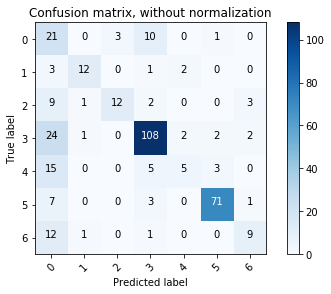

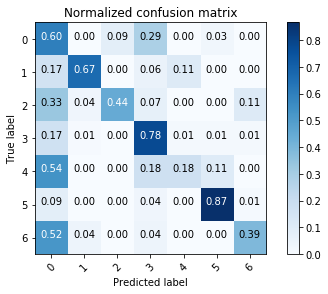

Wall time: 53min 26s


In [73]:
%%time
## MobileNet, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_160_3dim',
                                                    image_size=160, X_train=X_train_160_FM, y_train=y_train_160_FM,
                                                    X_test=X_test_160_FM, y_test=y_test_160_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 121s 39ms/step - loss: 7.2667 - acc: 0.5142 - precision: 0.5145 - recall: 0.5142 - fmeasure: 0.5144
Epoch 2/200
3123/3123 [==============================] - 95s 30ms/step - loss: 7.8718 - acc: 0.4950 - precision: 0.4951 - recall: 0.4950 - fmeasure: 0.4951
Epoch 3/200
3123/3123 [==============================] - 84s 27ms/step - loss: 5.0942 - acc: 0.4819 - precision: 0.5389 - recall: 0.4284 - fmeasure: 0.4731
Epoch 4/200
3123/3123 [==============================] - 84s 27ms/step - loss: 3.0302 - acc: 0.4736 - precision: 0.5546 - recall: 0.2933 - fmeasure: 0.3744
Epoch 5/200
3123/3123 [==============================] - 84s 27ms/step - loss: 1.9695 - acc: 0.5536 - precision: 0.7288 - recall: 0.3964 - fmeasure: 0.5045
Epoch 6/200
3123/3123 [==============================] - 84s 27ms/step - loss: 1.6942 - acc: 0.6042 - precision: 0.7589 - recall: 0.4537 - fmeasure: 0.5585
Epoch 7/200
3123/3123 [==============================] - 84s 27

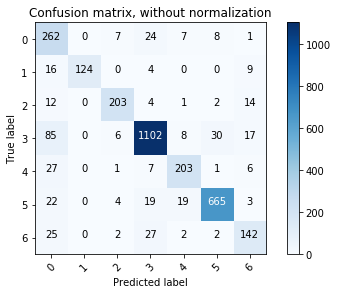

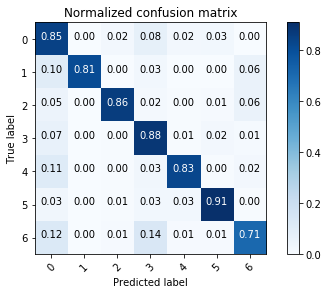

Confusion matrix, without normalization
[[ 20   0   1  10   2   2   0]
 [  3  11   0   3   0   0   1]
 [  5   1  14   1   1   1   4]
 [ 15   0   6 106   6   3   3]
 [  9   0   2   0  12   2   3]
 [  7   0   3   1   2  68   1]
 [  4   0   2   0   0   0  17]]
Normalized confusion matrix
[[0.57142857 0.         0.02857143 0.28571429 0.05714286 0.05714286
  0.        ]
 [0.16666667 0.61111111 0.         0.16666667 0.         0.
  0.05555556]
 [0.18518519 0.03703704 0.51851852 0.03703704 0.03703704 0.03703704
  0.14814815]
 [0.10791367 0.         0.04316547 0.76258993 0.04316547 0.02158273
  0.02158273]
 [0.32142857 0.         0.07142857 0.         0.42857143 0.07142857
  0.10714286]
 [0.08536585 0.         0.03658537 0.01219512 0.02439024 0.82926829
  0.01219512]
 [0.17391304 0.         0.08695652 0.         0.         0.
  0.73913043]]


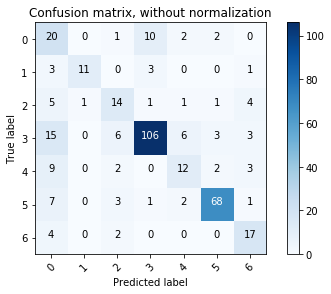

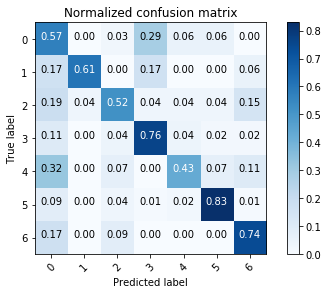

Wall time: 1h 30min 55s


In [74]:
%%time
## MobileNet, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_192_3dim',
                                                    image_size=192, X_train=X_train_192_FM, y_train=y_train_192_FM,
                                                    X_test=X_test_192_FM, y_test=y_test_192_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 137s 44ms/step - loss: 8.8080 - acc: 0.4425 - precision: 0.4426 - recall: 0.4425 - fmeasure: 0.4426
Epoch 2/200
3123/3123 [==============================] - 91s 29ms/step - loss: 9.0520 - acc: 0.4323 - precision: 0.4323 - recall: 0.4323 - fmeasure: 0.4323
Epoch 3/200
3123/3123 [==============================] - 90s 29ms/step - loss: 9.4663 - acc: 0.4083 - precision: 0.4084 - recall: 0.4079 - fmeasure: 0.4082
Epoch 4/200
3123/3123 [==============================] - 90s 29ms/step - loss: 8.9745 - acc: 0.3983 - precision: 0.4081 - recall: 0.3907 - fmeasure: 0.3984
Epoch 5/200
3123/3123 [==============================] - 91s 29ms/step - loss: 5.6734 - acc: 0.4201 - precision: 0.4646 - recall: 0.3061 - fmeasure: 0.3635
Epoch 6/200
3123/3123 [==============================] - 91s 29ms/step - loss: 3.2112 - acc: 0.4621 - precision: 0.5188 - recall: 0.2542 - fmeasure: 0.3323
Epoch 7/200
3123/3123 [==============================] - 90s 29

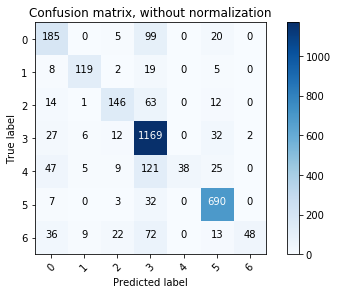

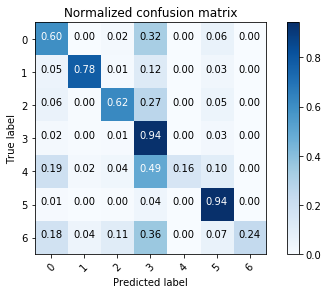

Confusion matrix, without normalization
[[ 13   0   1  19   0   2   0]
 [  1  12   1   4   0   0   0]
 [  2   1   8   9   1   6   0]
 [  7   0   2 123   0   7   0]
 [  5   1   3  16   0   3   0]
 [  2   0   3   7   0  70   0]
 [  7   0   7   6   0   2   1]]
Normalized confusion matrix
[[0.37142857 0.         0.02857143 0.54285714 0.         0.05714286
  0.        ]
 [0.05555556 0.66666667 0.05555556 0.22222222 0.         0.
  0.        ]
 [0.07407407 0.03703704 0.2962963  0.33333333 0.03703704 0.22222222
  0.        ]
 [0.05035971 0.         0.01438849 0.88489209 0.         0.05035971
  0.        ]
 [0.17857143 0.03571429 0.10714286 0.57142857 0.         0.10714286
  0.        ]
 [0.02439024 0.         0.03658537 0.08536585 0.         0.85365854
  0.        ]
 [0.30434783 0.         0.30434783 0.26086957 0.         0.08695652
  0.04347826]]


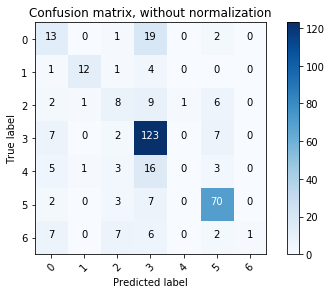

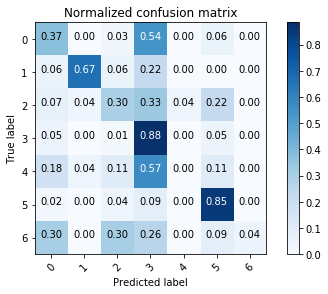

Wall time: 1h 59min 7s


In [76]:
%%time
## MobileNet, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_224_3dim',
                                                    image_size=224, X_train=X_train_224_FM, y_train=y_train_224_FM,
                                                    X_test=X_test_224_FM, y_test=y_test_224_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 75s 24ms/step - loss: 2.0231 - acc: 0.3919 - precision: 0.2385 - recall: 0.0752 - fmeasure: 0.1031
Epoch 2/200
3123/3123 [==============================] - 41s 13ms/step - loss: 1.6624 - acc: 0.3964 - precision: 0.2371 - recall: 0.0612 - fmeasure: 0.0891
Epoch 3/200
3123/3123 [==============================] - 41s 13ms/step - loss: 1.6173 - acc: 0.4207 - precision: 0.3138 - recall: 0.0996 - fmeasure: 0.1396
Epoch 4/200
3123/3123 [==============================] - 42s 13ms/step - loss: 1.4791 - acc: 0.4841 - precision: 0.5730 - recall: 0.2184 - fmeasure: 0.2977
Epoch 5/200
3123/3123 [==============================] - 42s 13ms/step - loss: 1.2533 - acc: 0.5632 - precision: 0.7221 - recall: 0.3762 - fmeasure: 0.4796
Epoch 6/200
3123/3123 [==============================] - 42s 13ms/step - loss: 1.1476 - acc: 0.6052 - precision: 0.7467 - recall: 0.4454 - fmeasure: 0.5436
Epoch 7/200
3123/3123 [==============================] - 42s 13m

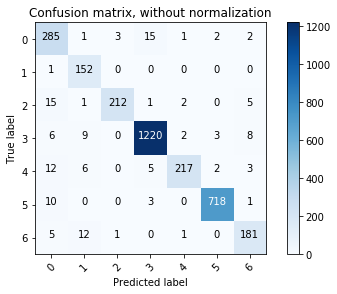

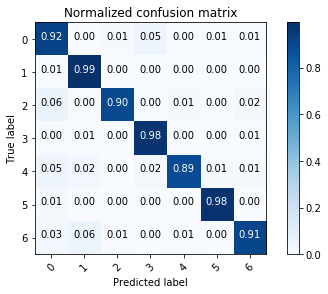

Confusion matrix, without normalization
[[ 24   0   0   7   1   2   1]
 [  1  14   0   2   0   0   1]
 [  3   2  13   2   0   1   6]
 [ 11   5   3 110   1   1   8]
 [  5   1   2   7   4   6   3]
 [  5   0   2   1   2  70   2]
 [  3   5   1   4   0   1   9]]
Normalized confusion matrix
[[0.68571429 0.         0.         0.2        0.02857143 0.05714286
  0.02857143]
 [0.05555556 0.77777778 0.         0.11111111 0.         0.
  0.05555556]
 [0.11111111 0.07407407 0.48148148 0.07407407 0.         0.03703704
  0.22222222]
 [0.07913669 0.03597122 0.02158273 0.79136691 0.00719424 0.00719424
  0.05755396]
 [0.17857143 0.03571429 0.07142857 0.25       0.14285714 0.21428571
  0.10714286]
 [0.06097561 0.         0.02439024 0.01219512 0.02439024 0.85365854
  0.02439024]
 [0.13043478 0.2173913  0.04347826 0.17391304 0.         0.04347826
  0.39130435]]


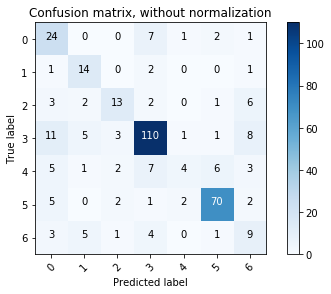

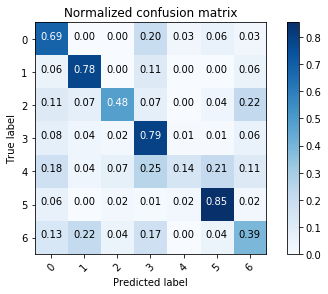

Wall time: 47min 49s


In [78]:
%%time
## SqueezeNet, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_128_3dim',
                                                    image_size=128, X_train=X_train_128_FM, y_train=y_train_128_FM,
                                                    X_test=X_test_128_FM, y_test=y_test_128_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 75s 24ms/step - loss: 1.9064 - acc: 0.3746 - precision: 0.2533 - recall: 0.0717 - fmeasure: 0.0995
Epoch 2/200
3123/3123 [==============================] - 43s 14ms/step - loss: 1.6851 - acc: 0.3900 - precision: 0.2966 - recall: 0.0688 - fmeasure: 0.1045
Epoch 3/200
3123/3123 [==============================] - 43s 14ms/step - loss: 1.5226 - acc: 0.4358 - precision: 0.4835 - recall: 0.1556 - fmeasure: 0.2207
Epoch 4/200
3123/3123 [==============================] - 43s 14ms/step - loss: 1.3308 - acc: 0.5274 - precision: 0.6634 - recall: 0.3164 - fmeasure: 0.4109
Epoch 5/200
3123/3123 [==============================] - 43s 14ms/step - loss: 1.1513 - acc: 0.6142 - precision: 0.7413 - recall: 0.4352 - fmeasure: 0.5347
Epoch 6/200
3123/3123 [==============================] - 43s 14ms/step - loss: 1.0613 - acc: 0.6257 - precision: 0.7798 - recall: 0.4890 - fmeasure: 0.5869
Epoch 7/200
3123/3123 [==============================] - 43s 14m

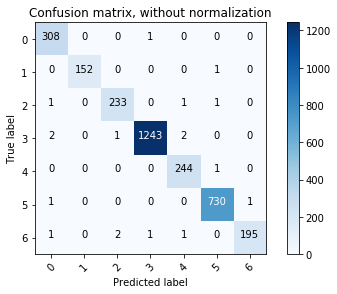

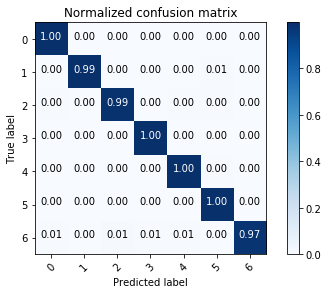

Confusion matrix, without normalization
[[ 25   0   0   9   0   1   0]
 [  1  12   0   3   0   0   2]
 [  5   1  12   1   2   3   3]
 [  4   0   1 126   3   5   0]
 [  4   0   1   5  10   7   1]
 [  0   0   3   2   2  75   0]
 [  2   2   2   2   2   0  13]]
Normalized confusion matrix
[[0.71428571 0.         0.         0.25714286 0.         0.02857143
  0.        ]
 [0.05555556 0.66666667 0.         0.16666667 0.         0.
  0.11111111]
 [0.18518519 0.03703704 0.44444444 0.03703704 0.07407407 0.11111111
  0.11111111]
 [0.02877698 0.         0.00719424 0.90647482 0.02158273 0.03597122
  0.        ]
 [0.14285714 0.         0.03571429 0.17857143 0.35714286 0.25
  0.03571429]
 [0.         0.         0.03658537 0.02439024 0.02439024 0.91463415
  0.        ]
 [0.08695652 0.08695652 0.08695652 0.08695652 0.08695652 0.
  0.56521739]]


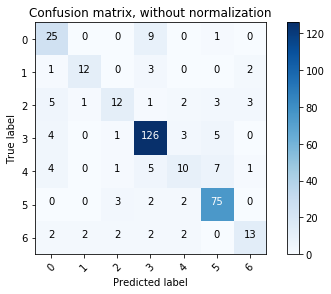

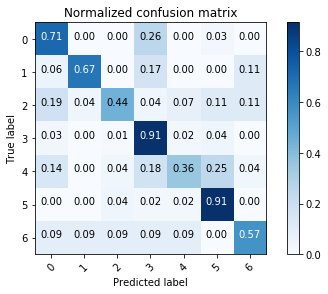

Wall time: 53min 13s


In [79]:
%%time
## SqueezeNet, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_160_3dim',
                                                    image_size=160, X_train=X_train_160_FM, y_train=y_train_160_FM,
                                                    X_test=X_test_160_FM, y_test=y_test_160_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 86s 27ms/step - loss: 9.6733 - acc: 0.3990 - precision: 0.3990 - recall: 0.3990 - fmeasure: 0.3990
Epoch 2/200
3123/3123 [==============================] - 46s 15ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 3/200
3123/3123 [==============================] - 46s 15ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 4/200
3123/3123 [==============================] - 46s 15ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 5/200
3123/3123 [==============================] - 47s 15ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 6/200
3123/3123 [==============================] - 46s 15ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 7/200
3123/3123 [==============================] - 46s 15m

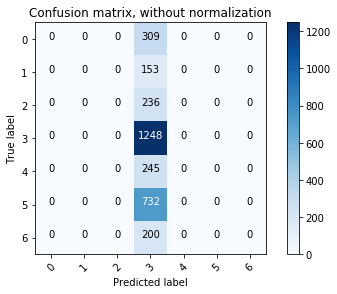

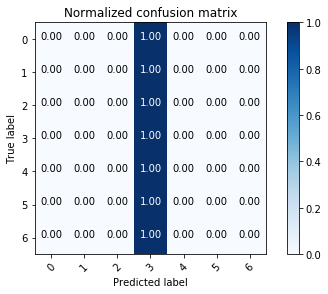

Confusion matrix, without normalization
[[  0   0   0  35   0   0   0]
 [  0   0   0  18   0   0   0]
 [  0   0   0  27   0   0   0]
 [  0   0   0 139   0   0   0]
 [  0   0   0  28   0   0   0]
 [  0   0   0  82   0   0   0]
 [  0   0   0  23   0   0   0]]
Normalized confusion matrix
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


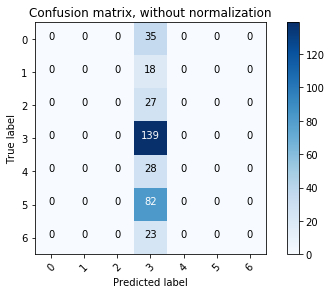

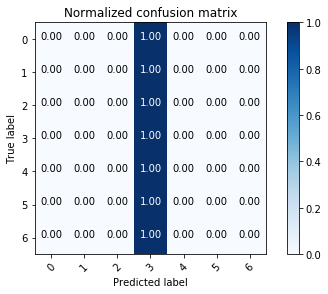

Wall time: 10min 30s


In [81]:
%%time
## SqueezeNet, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_192_3dim',
                                                    image_size=192, X_train=X_train_192_FM, y_train=y_train_192_FM,
                                                    X_test=X_test_192_FM, y_test=y_test_192_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 88s 28ms/step - loss: 9.6858 - acc: 0.3987 - precision: 0.3987 - recall: 0.3987 - fmeasure: 0.3987
Epoch 2/200
3123/3123 [==============================] - 49s 16ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 3/200
3123/3123 [==============================] - 49s 16ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 4/200
3123/3123 [==============================] - 49s 16ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 5/200
3123/3123 [==============================] - 50s 16ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 6/200
3123/3123 [==============================] - 49s 16ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 7/200
3123/3123 [==============================] - 49s 16m

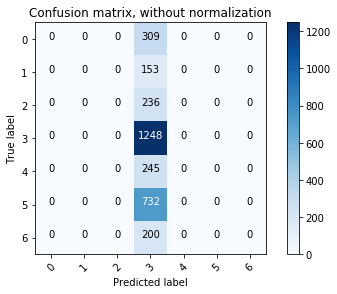

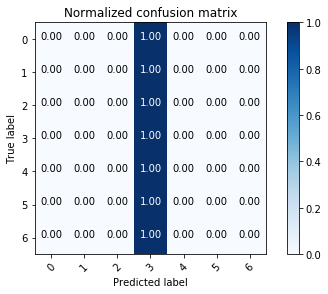

Confusion matrix, without normalization
[[  0   0   0  35   0   0   0]
 [  0   0   0  18   0   0   0]
 [  0   0   0  27   0   0   0]
 [  0   0   0 139   0   0   0]
 [  0   0   0  28   0   0   0]
 [  0   0   0  82   0   0   0]
 [  0   0   0  23   0   0   0]]
Normalized confusion matrix
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


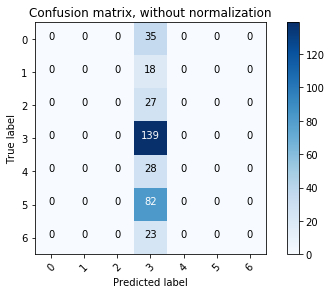

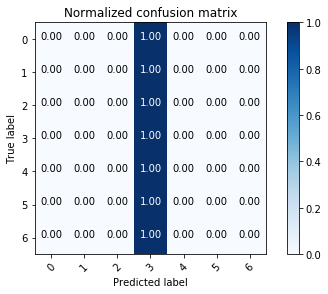

Wall time: 25min 9s


In [83]:
%%time
## SqueezeNet, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_224_3dim',
                                                    image_size=224, X_train=X_train_224_FM, y_train=y_train_224_FM,
                                                    X_test=X_test_224_FM, y_test=y_test_224_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 176s 56ms/step - loss: 1.6244 - acc: 0.4643 - precision: 0.5448 - recall: 0.2155 - fmeasure: 0.2969
Epoch 2/200
3123/3123 [==============================] - 131s 42ms/step - loss: 1.3807 - acc: 0.6004 - precision: 0.7667 - recall: 0.4169 - fmeasure: 0.5283
Epoch 3/200
3123/3123 [==============================] - 132s 42ms/step - loss: 2.0407 - acc: 0.5626 - precision: 0.6841 - recall: 0.3625 - fmeasure: 0.4628
Epoch 4/200
3123/3123 [==============================] - 131s 42ms/step - loss: 2.3532 - acc: 0.5405 - precision: 0.6443 - recall: 0.3705 - fmeasure: 0.4607
Epoch 5/200
3123/3123 [==============================] - 131s 42ms/step - loss: 2.0867 - acc: 0.5786 - precision: 0.6865 - recall: 0.4153 - fmeasure: 0.5086
Epoch 6/200
3123/3123 [==============================] - 132s 42ms/step - loss: 2.1213 - acc: 0.5719 - precision: 0.6909 - recall: 0.4243 - fmeasure: 0.5178
Epoch 7/200
3123/3123 [==============================] - 1

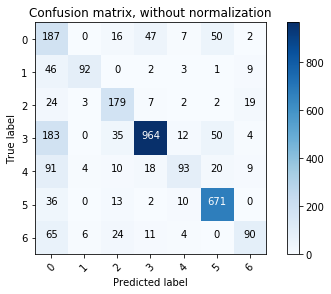

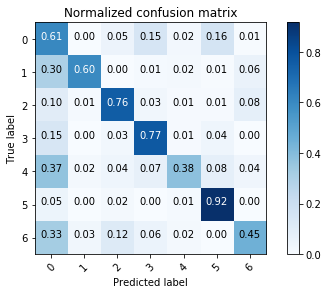

Confusion matrix, without normalization
[[16  0  3  7  0  9  0]
 [ 6 10  1  0  0  0  1]
 [ 7  1 16  0  0  1  2]
 [26  0  4 92  4 13  0]
 [11  0  3  3  2  6  3]
 [13  0  2  3  1 63  0]
 [ 4  0  2  4  0  1 12]]
Normalized confusion matrix
[[0.45714286 0.         0.08571429 0.2        0.         0.25714286
  0.        ]
 [0.33333333 0.55555556 0.05555556 0.         0.         0.
  0.05555556]
 [0.25925926 0.03703704 0.59259259 0.         0.         0.03703704
  0.07407407]
 [0.18705036 0.         0.02877698 0.6618705  0.02877698 0.09352518
  0.        ]
 [0.39285714 0.         0.10714286 0.10714286 0.07142857 0.21428571
  0.10714286]
 [0.15853659 0.         0.02439024 0.03658537 0.01219512 0.76829268
  0.        ]
 [0.17391304 0.         0.08695652 0.17391304 0.         0.04347826
  0.52173913]]


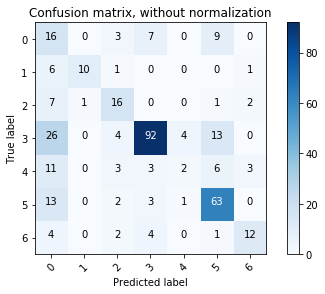

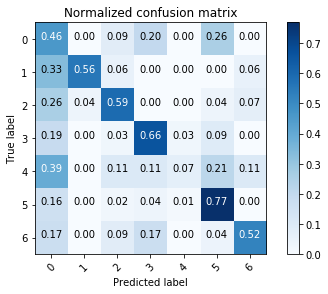

Wall time: 30min 19s


In [84]:
%%time
## Xception, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_128_3dim',
                                                    image_size=128, X_train=X_train_128_FM, y_train=y_train_128_FM,
                                                    X_test=X_test_128_FM, y_test=y_test_128_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 200s 64ms/step - loss: 1.5618 - acc: 0.4787 - precision: 0.6429 - recall: 0.2289 - fmeasure: 0.3210
Epoch 2/200
3123/3123 [==============================] - 137s 44ms/step - loss: 1.4823 - acc: 0.5408 - precision: 0.7526 - recall: 0.3455 - fmeasure: 0.4647
Epoch 3/200
3123/3123 [==============================] - 137s 44ms/step - loss: 1.5891 - acc: 0.5812 - precision: 0.7631 - recall: 0.3980 - fmeasure: 0.5103
Epoch 4/200
3123/3123 [==============================] - 137s 44ms/step - loss: 2.0507 - acc: 0.5776 - precision: 0.7129 - recall: 0.4284 - fmeasure: 0.5265
Epoch 5/200
3123/3123 [==============================] - 137s 44ms/step - loss: 2.0522 - acc: 0.5632 - precision: 0.6962 - recall: 0.4079 - fmeasure: 0.5054
Epoch 6/200
3123/3123 [==============================] - 138s 44ms/step - loss: 2.3467 - acc: 0.5101 - precision: 0.5992 - recall: 0.2991 - fmeasure: 0.3879
Epoch 7/200
3123/3123 [==============================] - 1

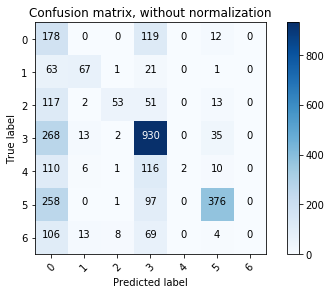

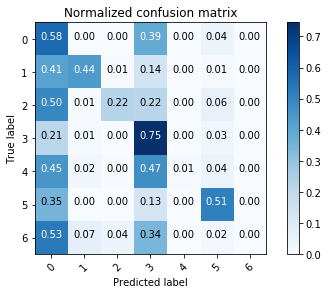

Confusion matrix, without normalization
[[21  0  0 11  0  3  0]
 [12  4  0  1  0  1  0]
 [13  1  4  9  0  0  0]
 [38  1  0 96  0  4  0]
 [13  0  2 13  0  0  0]
 [34  0  1 11  0 36  0]
 [15  0  1  6  0  0  1]]
Normalized confusion matrix
[[0.6        0.         0.         0.31428571 0.         0.08571429
  0.        ]
 [0.66666667 0.22222222 0.         0.05555556 0.         0.05555556
  0.        ]
 [0.48148148 0.03703704 0.14814815 0.33333333 0.         0.
  0.        ]
 [0.27338129 0.00719424 0.         0.69064748 0.         0.02877698
  0.        ]
 [0.46428571 0.         0.07142857 0.46428571 0.         0.
  0.        ]
 [0.41463415 0.         0.01219512 0.13414634 0.         0.43902439
  0.        ]
 [0.65217391 0.         0.04347826 0.26086957 0.         0.
  0.04347826]]


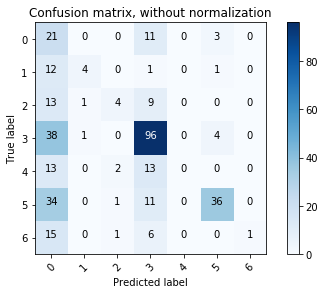

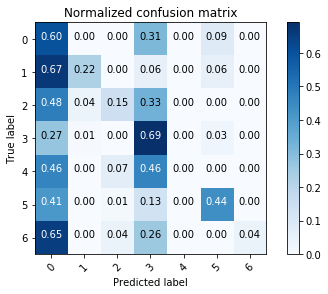

Wall time: 32min 30s


In [87]:
%%time
## Xception, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_160_3dim',
                                                    image_size=160, X_train=X_train_160_FM, y_train=y_train_160_FM,
                                                    X_test=X_test_160_FM, y_test=y_test_160_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

In [11]:
parameters_df = pd.read_csv('./PARAMETERS_AND_RESULTS/11_04_params_France_WITH_RETRAIN.csv', sep='\t', index_col=0)
results_df = pd.read_csv('./PARAMETERS_AND_RESULTS/11_04_results_France_WITH_RETRAIN.csv', sep='\t', index_col=0)

Epoch 1/200
3123/3123 [==============================] - 116s 37ms/step - loss: 1.5197 - acc: 0.4576 - precision: 0.5667 - recall: 0.2507 - fmeasure: 0.3352
Epoch 2/200
3123/3123 [==============================] - 107s 34ms/step - loss: 1.2278 - acc: 0.6314 - precision: 0.7874 - recall: 0.4886 - fmeasure: 0.5930
Epoch 3/200
3123/3123 [==============================] - 108s 35ms/step - loss: 2.1860 - acc: 0.5437 - precision: 0.6485 - recall: 0.3391 - fmeasure: 0.4301
Epoch 4/200
3123/3123 [==============================] - 108s 34ms/step - loss: 2.2227 - acc: 0.5796 - precision: 0.6850 - recall: 0.4150 - fmeasure: 0.5046
Epoch 5/200
3123/3123 [==============================] - 108s 35ms/step - loss: 2.3502 - acc: 0.5130 - precision: 0.5956 - recall: 0.3170 - fmeasure: 0.4013
Epoch 6/200
3123/3123 [==============================] - 107s 34ms/step - loss: 2.0584 - acc: 0.5578 - precision: 0.6555 - recall: 0.3890 - fmeasure: 0.4786
Epoch 7/200
3123/3123 [==============================] - 1

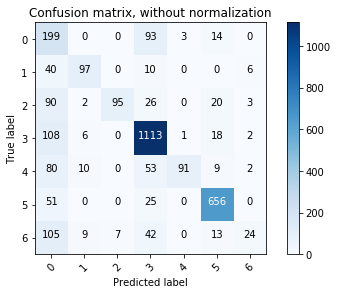

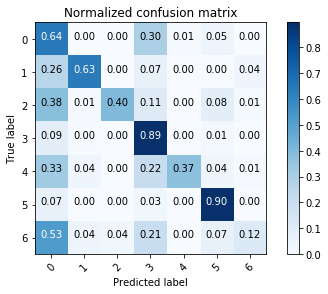

Confusion matrix, without normalization
[[ 18   0   0  14   1   2   0]
 [  6   9   0   2   0   0   1]
 [ 12   1   4   4   0   3   3]
 [ 13   0   0 121   0   5   0]
 [  9   2   0   9   3   5   0]
 [  4   0   0   5   0  73   0]
 [  5   0   0   9   0   3   6]]
Normalized confusion matrix
[[0.51428571 0.         0.         0.4        0.02857143 0.05714286
  0.        ]
 [0.33333333 0.5        0.         0.11111111 0.         0.
  0.05555556]
 [0.44444444 0.03703704 0.14814815 0.14814815 0.         0.11111111
  0.11111111]
 [0.09352518 0.         0.         0.8705036  0.         0.03597122
  0.        ]
 [0.32142857 0.07142857 0.         0.32142857 0.10714286 0.17857143
  0.        ]
 [0.04878049 0.         0.         0.06097561 0.         0.8902439
  0.        ]
 [0.2173913  0.         0.         0.39130435 0.         0.13043478
  0.26086957]]


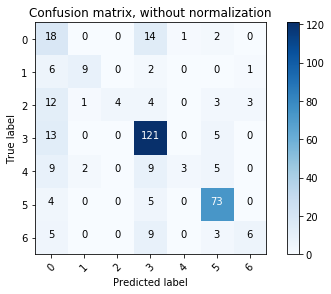

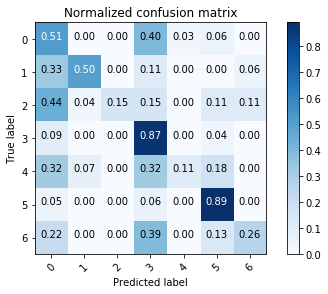

Wall time: 22min 31s


In [12]:
%%time
## Xception, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_192_3dim',
                                                    image_size=192, X_train=X_train_192_FM, y_train=y_train_192_FM,
                                                    X_test=X_test_192_FM, y_test=y_test_192_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 125s 40ms/step - loss: 1.4986 - acc: 0.4880 - precision: 0.6945 - recall: 0.3016 - fmeasure: 0.4087
Epoch 2/200
3123/3123 [==============================] - 119s 38ms/step - loss: 1.4063 - acc: 0.5764 - precision: 0.8345 - recall: 0.4073 - fmeasure: 0.5371
Epoch 3/200
3123/3123 [==============================] - 119s 38ms/step - loss: 2.3140 - acc: 0.5181 - precision: 0.6687 - recall: 0.3365 - fmeasure: 0.4384
Epoch 4/200
3123/3123 [==============================] - 119s 38ms/step - loss: 2.5551 - acc: 0.4284 - precision: 0.4812 - recall: 0.1495 - fmeasure: 0.2191
Epoch 5/200
3123/3123 [==============================] - 118s 38ms/step - loss: 2.4333 - acc: 0.4745 - precision: 0.5777 - recall: 0.2571 - fmeasure: 0.3474
Epoch 6/200
3123/3123 [==============================] - 119s 38ms/step - loss: 2.4609 - acc: 0.4784 - precision: 0.5702 - recall: 0.2683 - fmeasure: 0.3567
Epoch 7/200
3123/3123 [==============================] - 1

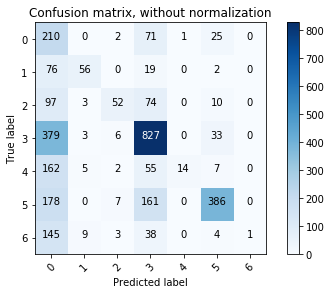

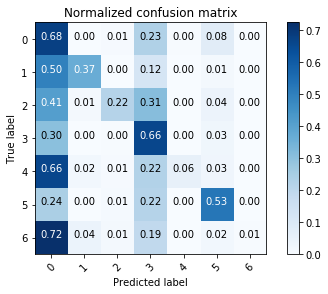

Confusion matrix, without normalization
[[23  0  0 11  0  1  0]
 [ 8  6  0  4  0  0  0]
 [15  1  6  5  0  0  0]
 [59  0  0 78  0  2  0]
 [17  0  0  7  0  4  0]
 [22  0  2 10  0 48  0]
 [16  0  0  5  0  2  0]]
Normalized confusion matrix
[[0.65714286 0.         0.         0.31428571 0.         0.02857143
  0.        ]
 [0.44444444 0.33333333 0.         0.22222222 0.         0.
  0.        ]
 [0.55555556 0.03703704 0.22222222 0.18518519 0.         0.
  0.        ]
 [0.42446043 0.         0.         0.56115108 0.         0.01438849
  0.        ]
 [0.60714286 0.         0.         0.25       0.         0.14285714
  0.        ]
 [0.26829268 0.         0.02439024 0.12195122 0.         0.58536585
  0.        ]
 [0.69565217 0.         0.         0.2173913  0.         0.08695652
  0.        ]]


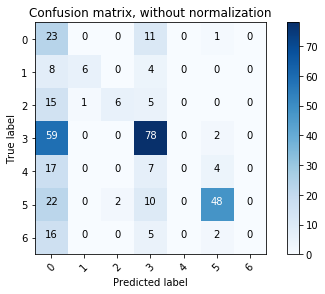

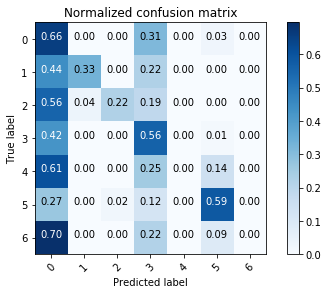

Wall time: 24min 57s


In [13]:
%%time
## Xception, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_224_3dim',
                                                    image_size=224, X_train=X_train_224_FM, y_train=y_train_224_FM,
                                                    X_test=X_test_224_FM, y_test=y_test_224_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 45s 14ms/step - loss: 10.2548 - acc: 0.3638 - precision: 0.3638 - recall: 0.3638 - fmeasure: 0.3638
Epoch 2/200
3123/3123 [==============================] - 41s 13ms/step - loss: 10.1725 - acc: 0.3689 - precision: 0.3689 - recall: 0.3689 - fmeasure: 0.3689
Epoch 3/200
3123/3123 [==============================] - 41s 13ms/step - loss: 10.2241 - acc: 0.3657 - precision: 0.3657 - recall: 0.3657 - fmeasure: 0.3657
Epoch 4/200
3123/3123 [==============================] - 41s 13ms/step - loss: 10.2293 - acc: 0.3654 - precision: 0.3654 - recall: 0.3654 - fmeasure: 0.3654
Epoch 5/200
3123/3123 [==============================] - 41s 13ms/step - loss: 10.1828 - acc: 0.3682 - precision: 0.3682 - recall: 0.3682 - fmeasure: 0.3682
Epoch 6/200
3123/3123 [==============================] - 41s 13ms/step - loss: 10.1674 - acc: 0.3692 - precision: 0.3692 - recall: 0.3692 - fmeasure: 0.3692
Epoch 7/200
3123/3123 [==============================] - 4

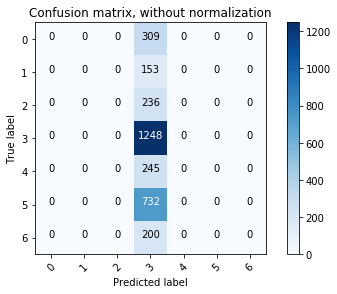

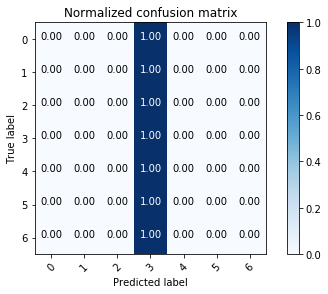

Confusion matrix, without normalization
[[  0   0   0  35   0   0   0]
 [  0   0   0  18   0   0   0]
 [  0   0   0  27   0   0   0]
 [  0   0   0 139   0   0   0]
 [  0   0   0  28   0   0   0]
 [  0   0   0  82   0   0   0]
 [  0   0   0  23   0   0   0]]
Normalized confusion matrix
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


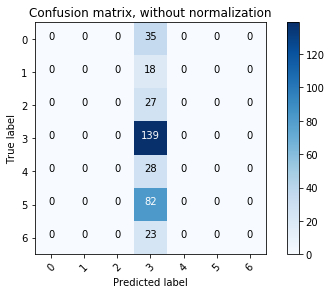

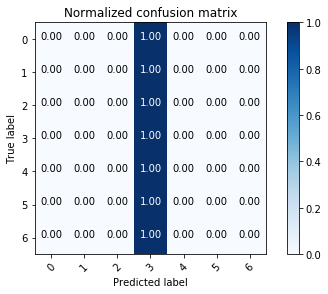

Wall time: 16min 36s


In [15]:
%%time
## VGG16, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_128_3dim',
                                                    image_size=128, X_train=X_train_128_FM, y_train=y_train_128_FM,
                                                    X_test=X_test_128_FM, y_test=y_test_128_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 60s 19ms/step - loss: 9.6984 - acc: 0.3977 - precision: 0.3977 - recall: 0.3977 - fmeasure: 0.3977
Epoch 2/200
3123/3123 [==============================] - 55s 18ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 3/200
3123/3123 [==============================] - 55s 18ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 4/200
3123/3123 [==============================] - 55s 18ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 5/200
3123/3123 [==============================] - 55s 18ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 6/200
3123/3123 [==============================] - 55s 18ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 7/200
3123/3123 [==============================] - 55s 18m

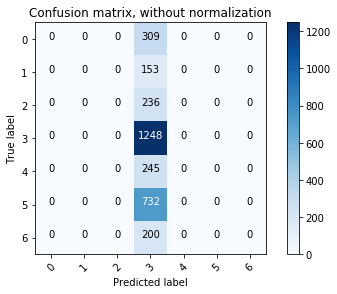

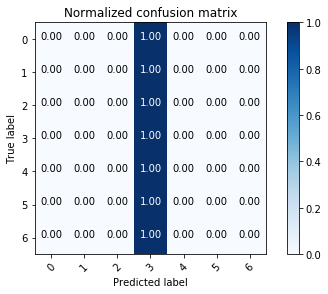

Confusion matrix, without normalization
[[  0   0   0  35   0   0   0]
 [  0   0   0  18   0   0   0]
 [  0   0   0  27   0   0   0]
 [  0   0   0 139   0   0   0]
 [  0   0   0  28   0   0   0]
 [  0   0   0  82   0   0   0]
 [  0   0   0  23   0   0   0]]
Normalized confusion matrix
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


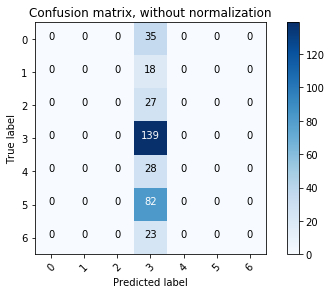

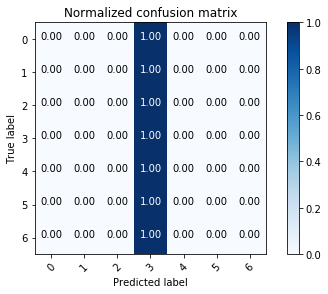

Wall time: 15min 12s


In [16]:
%%time
## VGG16, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_160_3dim',
                                                    image_size=160, X_train=X_train_160_FM, y_train=y_train_160_FM,
                                                    X_test=X_test_160_FM, y_test=y_test_160_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 71s 23ms/step - loss: 9.9027 - acc: 0.3842 - precision: 0.3842 - recall: 0.3842 - fmeasure: 0.3842
Epoch 2/200
3123/3123 [==============================] - 67s 21ms/step - loss: 9.7906 - acc: 0.3926 - precision: 0.3926 - recall: 0.3926 - fmeasure: 0.3926
Epoch 3/200
3123/3123 [==============================] - 67s 21ms/step - loss: 9.7854 - acc: 0.3929 - precision: 0.3929 - recall: 0.3929 - fmeasure: 0.3929
Epoch 4/200
3123/3123 [==============================] - 67s 22ms/step - loss: 9.7958 - acc: 0.3923 - precision: 0.3923 - recall: 0.3923 - fmeasure: 0.3923
Epoch 5/200
3123/3123 [==============================] - 67s 22ms/step - loss: 9.8370 - acc: 0.3897 - precision: 0.3897 - recall: 0.3897 - fmeasure: 0.3897
Epoch 6/200
3123/3123 [==============================] - 67s 21ms/step - loss: 9.8164 - acc: 0.3910 - precision: 0.3910 - recall: 0.3910 - fmeasure: 0.3910
Epoch 7/200
3123/3123 [==============================] - 67s 21m

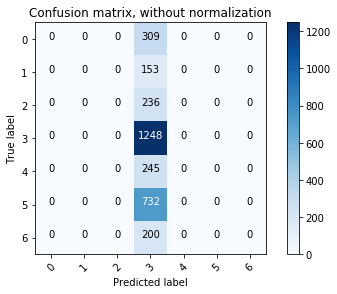

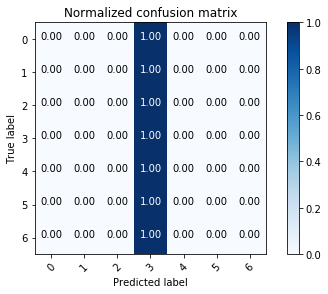

Confusion matrix, without normalization
[[  0   0   0  35   0   0   0]
 [  0   0   0  18   0   0   0]
 [  0   0   0  27   0   0   0]
 [  0   0   0 139   0   0   0]
 [  0   0   0  28   0   0   0]
 [  0   0   0  82   0   0   0]
 [  0   0   0  23   0   0   0]]
Normalized confusion matrix
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


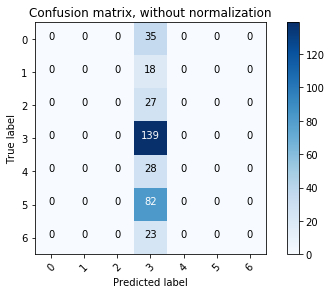

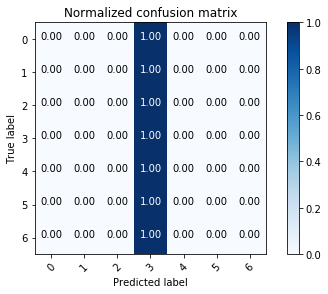

Wall time: 22min 56s


In [17]:
%%time
## VGG16, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_192_3dim',
                                                    image_size=192, X_train=X_train_192_FM, y_train=y_train_192_FM,
                                                    X_test=X_test_192_FM, y_test=y_test_192_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 91s 29ms/step - loss: 11.9073 - acc: 0.2600 - precision: 0.2600 - recall: 0.2600 - fmeasure: 0.2600
Epoch 2/200
3123/3123 [==============================] - 85s 27ms/step - loss: 12.1234 - acc: 0.2478 - precision: 0.2478 - recall: 0.2478 - fmeasure: 0.2478
Epoch 3/200
3123/3123 [==============================] - 85s 27ms/step - loss: 11.9583 - acc: 0.2581 - precision: 0.2581 - recall: 0.2581 - fmeasure: 0.2581
Epoch 4/200
3123/3123 [==============================] - 85s 27ms/step - loss: 11.9118 - acc: 0.2610 - precision: 0.2610 - recall: 0.2610 - fmeasure: 0.2610
Epoch 5/200
3123/3123 [==============================] - 85s 27ms/step - loss: 12.0563 - acc: 0.2520 - precision: 0.2520 - recall: 0.2520 - fmeasure: 0.2520
Epoch 6/200
3123/3123 [==============================] - 85s 27ms/step - loss: 12.0047 - acc: 0.2552 - precision: 0.2552 - recall: 0.2552 - fmeasure: 0.2552
Epoch 7/200
3123/3123 [==============================] - 8

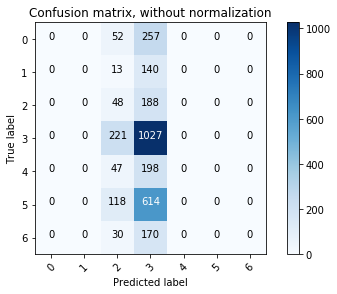

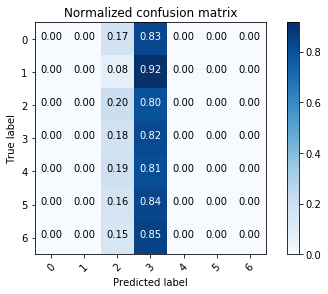

Confusion matrix, without normalization
[[  0   0  13  22   0   0   0]
 [  0   0   2  16   0   0   0]
 [  0   0   4  23   0   0   0]
 [  0   0  22 117   0   0   0]
 [  0   0  11  17   0   0   0]
 [  0   0  10  72   0   0   0]
 [  0   0   3  20   0   0   0]]
Normalized confusion matrix
[[0.         0.         0.37142857 0.62857143 0.         0.
  0.        ]
 [0.         0.         0.11111111 0.88888889 0.         0.
  0.        ]
 [0.         0.         0.14814815 0.85185185 0.         0.
  0.        ]
 [0.         0.         0.15827338 0.84172662 0.         0.
  0.        ]
 [0.         0.         0.39285714 0.60714286 0.         0.
  0.        ]
 [0.         0.         0.12195122 0.87804878 0.         0.
  0.        ]
 [0.         0.         0.13043478 0.86956522 0.         0.
  0.        ]]


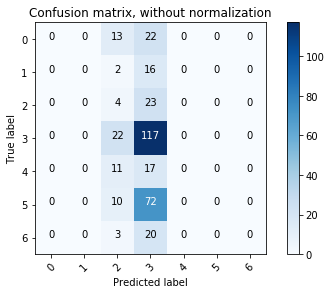

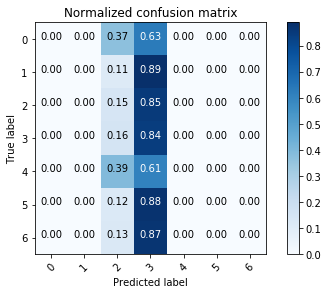

Wall time: 33min 13s


In [18]:
%%time
## VGG16, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_224_3dim',
                                                    image_size=224, X_train=X_train_224_FM, y_train=y_train_224_FM,
                                                    X_test=X_test_224_FM, y_test=y_test_224_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 53s 17ms/step - loss: 9.7000 - acc: 0.3980 - precision: 0.3980 - recall: 0.3980 - fmeasure: 0.3980
Epoch 2/200
3123/3123 [==============================] - 48s 15ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 3/200
3123/3123 [==============================] - 48s 16ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 4/200
3123/3123 [==============================] - 49s 16ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 5/200
3123/3123 [==============================] - 48s 16ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 6/200
3123/3123 [==============================] - 48s 16ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 7/200
3123/3123 [==============================] - 48s 15m

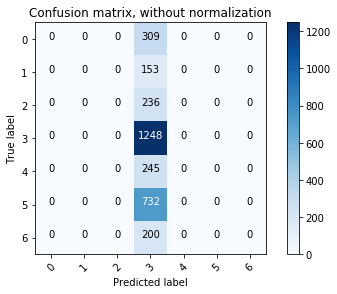

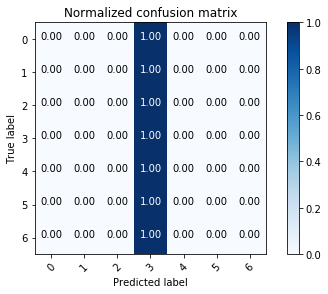

Confusion matrix, without normalization
[[  0   0   0  35   0   0   0]
 [  0   0   0  18   0   0   0]
 [  0   0   0  27   0   0   0]
 [  0   0   0 139   0   0   0]
 [  0   0   0  28   0   0   0]
 [  0   0   0  82   0   0   0]
 [  0   0   0  23   0   0   0]]
Normalized confusion matrix
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


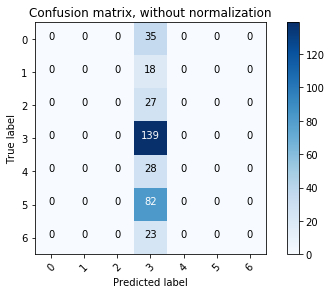

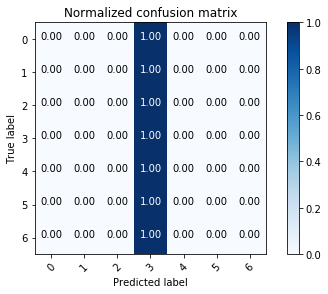

Wall time: 14min 59s


In [19]:
%%time
## VGG19, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_128_3dim',
                                                    image_size=128, X_train=X_train_128_FM, y_train=y_train_128_FM,
                                                    X_test=X_test_128_FM, y_test=y_test_128_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 70s 22ms/step - loss: 9.6906 - acc: 0.3983 - precision: 0.3983 - recall: 0.3983 - fmeasure: 0.3983
Epoch 2/200
3123/3123 [==============================] - 66s 21ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 3/200
3123/3123 [==============================] - 65s 21ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 4/200
3123/3123 [==============================] - 66s 21ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 5/200
3123/3123 [==============================] - 66s 21ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 6/200
3123/3123 [==============================] - 65s 21ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 7/200
3123/3123 [==============================] - 65s 21m

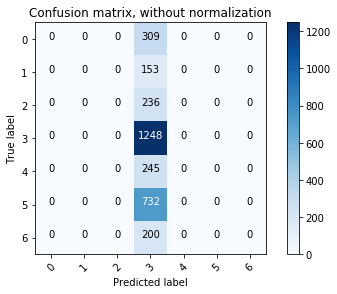

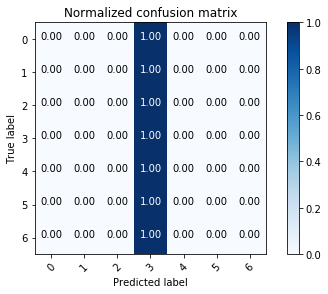

Confusion matrix, without normalization
[[  0   0   0  35   0   0   0]
 [  0   0   0  18   0   0   0]
 [  0   0   0  27   0   0   0]
 [  0   0   0 139   0   0   0]
 [  0   0   0  28   0   0   0]
 [  0   0   0  82   0   0   0]
 [  0   0   0  23   0   0   0]]
Normalized confusion matrix
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


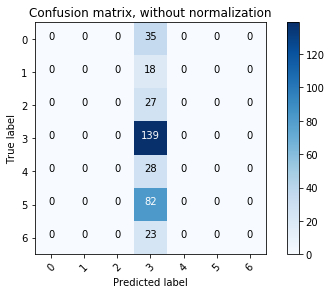

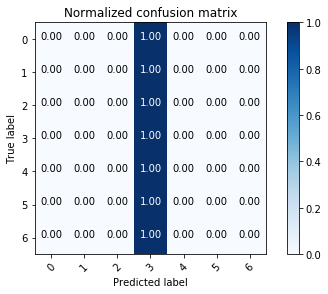

Wall time: 28min 57s


In [23]:
%%time
## VGG19, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_160_3dim',
                                                    image_size=160, X_train=X_train_160_FM, y_train=y_train_160_FM,
                                                    X_test=X_test_160_FM, y_test=y_test_160_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 84s 27ms/step - loss: 10.6594 - acc: 0.3381 - precision: 0.3381 - recall: 0.3381 - fmeasure: 0.3381
Epoch 2/200
3123/3123 [==============================] - 80s 26ms/step - loss: 10.5648 - acc: 0.3445 - precision: 0.3445 - recall: 0.3445 - fmeasure: 0.3445
Epoch 3/200
3123/3123 [==============================] - 80s 25ms/step - loss: 10.6112 - acc: 0.3417 - precision: 0.3417 - recall: 0.3417 - fmeasure: 0.3417
Epoch 4/200
3123/3123 [==============================] - 80s 25ms/step - loss: 10.5699 - acc: 0.3442 - precision: 0.3442 - recall: 0.3442 - fmeasure: 0.3442
Epoch 5/200
3123/3123 [==============================] - 80s 26ms/step - loss: 10.5596 - acc: 0.3449 - precision: 0.3449 - recall: 0.3449 - fmeasure: 0.3449
Epoch 6/200
3123/3123 [==============================] - 80s 26ms/step - loss: 10.4770 - acc: 0.3500 - precision: 0.3500 - recall: 0.3500 - fmeasure: 0.3500
Epoch 7/200
3123/3123 [==============================] - 8

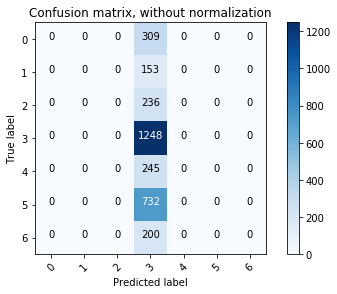

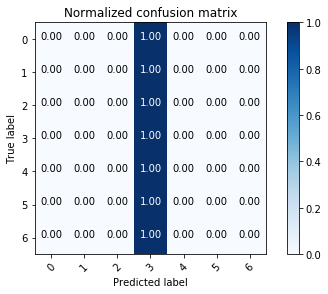

Confusion matrix, without normalization
[[  0   0   0  35   0   0   0]
 [  0   0   0  18   0   0   0]
 [  0   0   0  27   0   0   0]
 [  0   0   0 139   0   0   0]
 [  0   0   0  28   0   0   0]
 [  0   0   0  82   0   0   0]
 [  0   0   0  23   0   0   0]]
Normalized confusion matrix
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


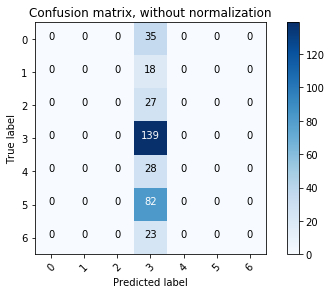

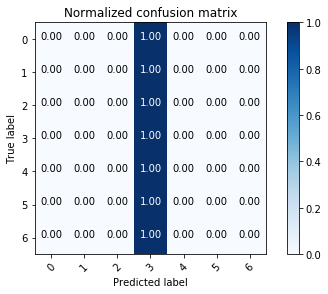

Wall time: 27min 15s


In [21]:
%%time
## VGG19, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_192_3dim',
                                                    image_size=192, X_train=X_train_192_FM, y_train=y_train_192_FM,
                                                    X_test=X_test_192_FM, y_test=y_test_192_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 104s 33ms/step - loss: 9.6855 - acc: 0.3983 - precision: 0.3984 - recall: 0.3983 - fmeasure: 0.3984
Epoch 2/200
3123/3123 [==============================] - 101s 32ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 3/200
3123/3123 [==============================] - 101s 32ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 4/200
3123/3123 [==============================] - 100s 32ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 5/200
3123/3123 [==============================] - 101s 32ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 6/200
3123/3123 [==============================] - 101s 32ms/step - loss: 9.6771 - acc: 0.3996 - precision: 0.3996 - recall: 0.3996 - fmeasure: 0.3996
Epoch 7/200
3123/3123 [==============================] - 1

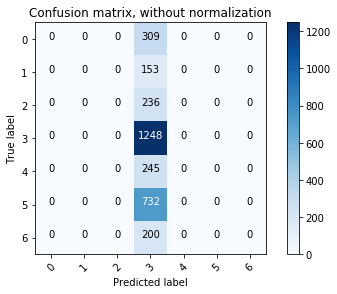

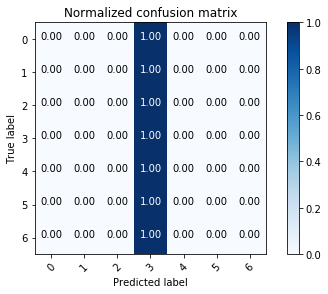

Confusion matrix, without normalization
[[  0   0   0  35   0   0   0]
 [  0   0   0  18   0   0   0]
 [  0   0   0  27   0   0   0]
 [  0   0   0 139   0   0   0]
 [  0   0   0  28   0   0   0]
 [  0   0   0  82   0   0   0]
 [  0   0   0  23   0   0   0]]
Normalized confusion matrix
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


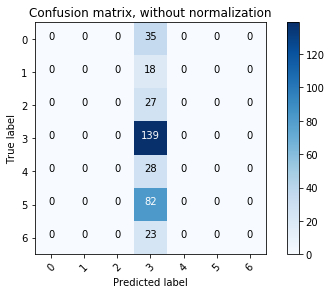

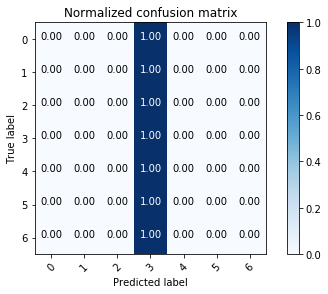

Wall time: 1h 6min 1s


In [22]:
%%time
## VGG19, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_224_3dim',
                                                    image_size=224, X_train=X_train_224_FM, y_train=y_train_224_FM,
                                                    X_test=X_test_224_FM, y_test=y_test_224_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

In [10]:
%%time
# Now load another dataset

X_128_F_ByMeaningLarge, y_128_F_ByMeaningLarge = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByMeaningLarge_128_3dim",
                                            ["AllTransport", "Restaurant"],
                                            already_transformed=True)   

X_160_F_ByMeaningLarge, y_160_F_ByMeaningLarge = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByMeaningLarge_160_3dim",
                                            ["AllTransport", "Restaurant"],
                                            already_transformed=True)   

X_192_F_ByMeaningLarge, y_192_F_ByMeaningLarge = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByMeaningLarge_192_3dim",
                                            ["AllTransport", "Restaurant"],
                                            already_transformed=True)   

X_224_F_ByMeaningLarge, y_224_F_ByMeaningLarge = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByMeaningLarge_224_3dim",
                                            ["AllTransport", "Restaurant"],
                                            already_transformed=True)   

#Than divide all of them to train and test

X_train_128_FML, y_train_128_FML, X_test_128_FML, y_test_128_FML = divide_to_train_end_test(X_128_F_ByMeaningLarge,
                                                                                        y_128_F_ByMeaningLarge, num_categories=2)
X_train_160_FML, y_train_160_FML, X_test_160_FML, y_test_160_FML = divide_to_train_end_test(X_160_F_ByMeaningLarge,
                                                                                        y_160_F_ByMeaningLarge, num_categories=2)
X_train_192_FML, y_train_192_FML, X_test_192_FML, y_test_192_FML = divide_to_train_end_test(X_192_F_ByMeaningLarge,
                                                                                        y_192_F_ByMeaningLarge, num_categories=2)
X_train_224_FML, y_train_224_FML, X_test_224_FML, y_test_224_FML = divide_to_train_end_test(X_224_F_ByMeaningLarge,
                                                                                        y_224_F_ByMeaningLarge, num_categories=2)

Wall time: 31.8 s


Epoch 1/200
2977/2977 [==============================] - 67s 22ms/step - loss: 3.7617 - acc: 0.7148 - precision: 0.7148 - recall: 0.7148 - fmeasure: 0.7148
Epoch 2/200
2977/2977 [==============================] - 60s 20ms/step - loss: 4.2190 - acc: 0.7098 - precision: 0.7098 - recall: 0.7098 - fmeasure: 0.7098
Epoch 3/200
2977/2977 [==============================] - 59s 20ms/step - loss: 2.1659 - acc: 0.7874 - precision: 0.7874 - recall: 0.7874 - fmeasure: 0.7874
Epoch 4/200
2977/2977 [==============================] - 59s 20ms/step - loss: 1.0681 - acc: 0.8069 - precision: 0.8069 - recall: 0.8069 - fmeasure: 0.8069
Epoch 5/200
2977/2977 [==============================] - 59s 20ms/step - loss: 1.0345 - acc: 0.7985 - precision: 0.7985 - recall: 0.7985 - fmeasure: 0.7985
Epoch 6/200
2977/2977 [==============================] - 58s 20ms/step - loss: 1.0263 - acc: 0.7964 - precision: 0.7964 - recall: 0.7964 - fmeasure: 0.7964
Epoch 7/200
2977/2977 [==============================] - 58s 20m

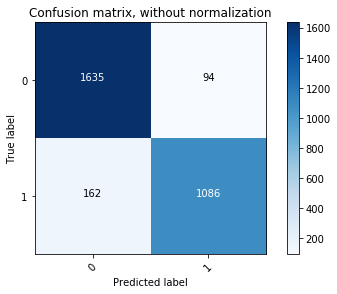

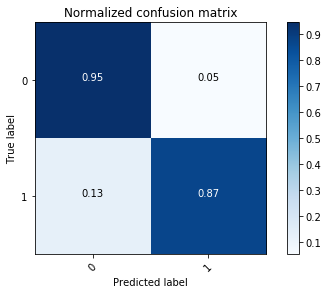

Confusion matrix, without normalization
[[176  17]
 [ 35 104]]
Normalized confusion matrix
[[0.9119171  0.0880829 ]
 [0.25179856 0.74820144]]


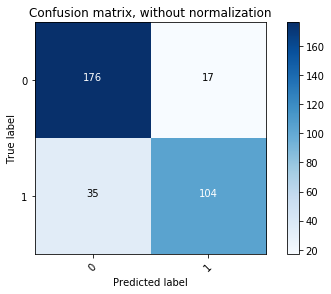

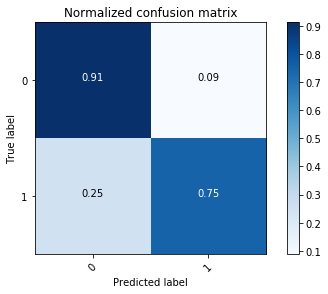

Wall time: 38min 13s


In [25]:
%%time
## MobileNet, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_128_3dim',
                                                    image_size=128, X_train=X_train_128_FML, y_train=y_train_128_FML,
                                                    X_test=X_test_128_FML, y_test=y_test_128_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 89s 30ms/step - loss: 6.7553 - acc: 0.5794 - precision: 0.5794 - recall: 0.5794 - fmeasure: 0.5794
Epoch 2/200
2977/2977 [==============================] - 75s 25ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 3/200
2977/2977 [==============================] - 73s 25ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 4/200
2977/2977 [==============================] - 76s 25ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 5/200
2977/2977 [==============================] - 77s 26ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 6/200
2977/2977 [==============================] - 74s 25ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 7/200
2977/2977 [==============================] - 75s 25m

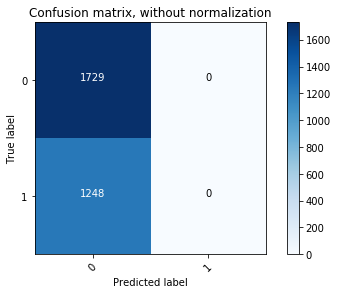

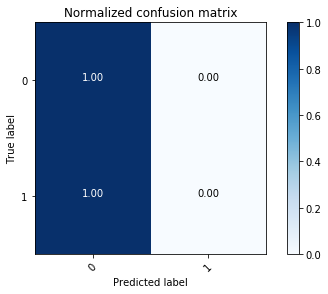

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


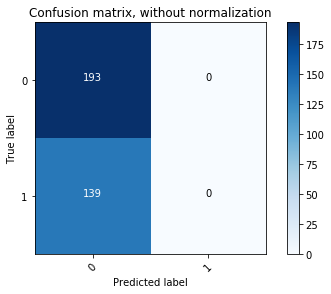

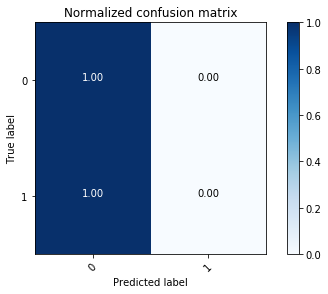

Wall time: 14min 22s


In [26]:
%%time
## MobileNet, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_160_3dim',
                                                    image_size=160, X_train=X_train_160_FML, y_train=y_train_160_FML,
                                                    X_test=X_test_160_FML, y_test=y_test_160_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 79s 26ms/step - loss: 4.4574 - acc: 0.6829 - precision: 0.6829 - recall: 0.6829 - fmeasure: 0.6829
Epoch 2/200
2977/2977 [==============================] - 65s 22ms/step - loss: 4.0070 - acc: 0.7373 - precision: 0.7373 - recall: 0.7373 - fmeasure: 0.7373
Epoch 3/200
2977/2977 [==============================] - 78s 26ms/step - loss: 5.4171 - acc: 0.6574 - precision: 0.6574 - recall: 0.6574 - fmeasure: 0.6574
Epoch 4/200
2977/2977 [==============================] - 80s 27ms/step - loss: 3.9525 - acc: 0.7390 - precision: 0.7390 - recall: 0.7390 - fmeasure: 0.7390
Epoch 5/200
2977/2977 [==============================] - 80s 27ms/step - loss: 3.6961 - acc: 0.7538 - precision: 0.7538 - recall: 0.7538 - fmeasure: 0.7538
Epoch 6/200
2977/2977 [==============================] - 68s 23ms/step - loss: 3.6182 - acc: 0.7612 - precision: 0.7612 - recall: 0.7612 - fmeasure: 0.7612
Epoch 7/200
2977/2977 [==============================] - 64s 21m

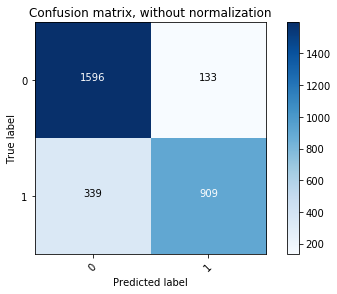

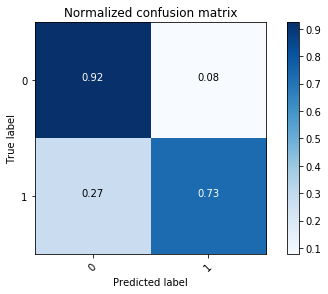

Confusion matrix, without normalization
[[179  14]
 [ 43  96]]
Normalized confusion matrix
[[0.92746114 0.07253886]
 [0.30935252 0.69064748]]


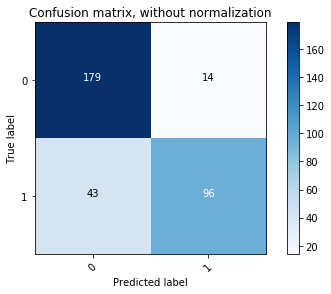

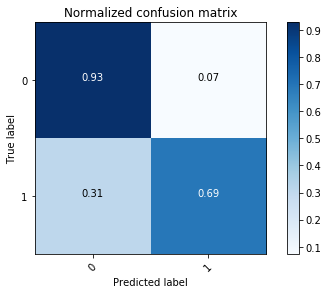

Wall time: 57min 3s


In [27]:
%%time
## MobileNet, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_160_3dim',
                                                    image_size=160, X_train=X_train_160_FML, y_train=y_train_160_FML,
                                                    X_test=X_test_160_FML, y_test=y_test_160_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 102s 34ms/step - loss: 6.1442 - acc: 0.5989 - precision: 0.5989 - recall: 0.5989 - fmeasure: 0.5989
Epoch 2/200
2977/2977 [==============================] - 84s 28ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 3/200
2977/2977 [==============================] - 84s 28ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 4/200
2977/2977 [==============================] - 85s 28ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 5/200
2977/2977 [==============================] - 87s 29ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 6/200
2977/2977 [==============================] - 84s 28ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 7/200
2977/2977 [==============================] - 81s 27

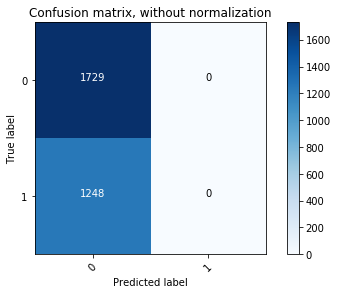

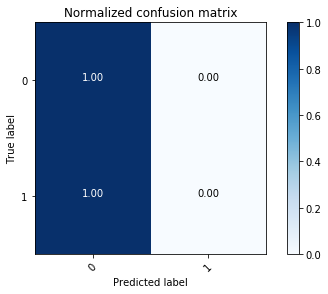

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


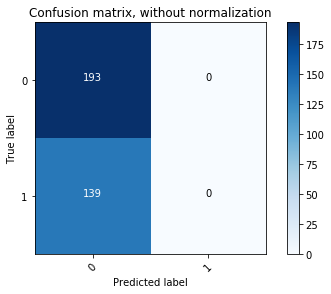

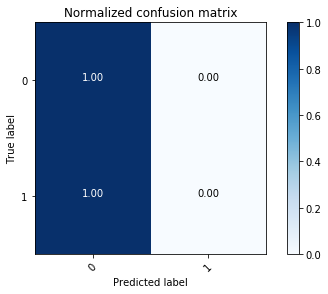

Wall time: 16min 58s


In [29]:
%%time
## MobileNet, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_192_3dim',
                                                    image_size=192, X_train=X_train_192_FML, y_train=y_train_192_FML,
                                                    X_test=X_test_192_FML, y_test=y_test_192_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 110s 37ms/step - loss: 9.3321 - acc: 0.4189 - precision: 0.4189 - recall: 0.4189 - fmeasure: 0.4189
Epoch 2/200
2977/2977 [==============================] - 93s 31ms/step - loss: 9.2534 - acc: 0.4246 - precision: 0.4246 - recall: 0.4246 - fmeasure: 0.4246
Epoch 3/200
2977/2977 [==============================] - 93s 31ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 4/200
2977/2977 [==============================] - 91s 31ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 5/200
2977/2977 [==============================] - 91s 30ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 6/200
2977/2977 [==============================] - 95s 32ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 7/200
2977/2977 [==============================] - 89s 30

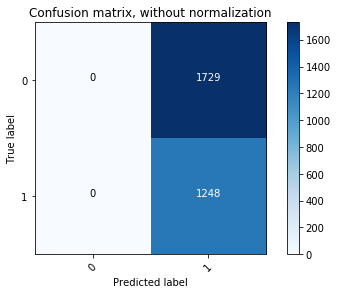

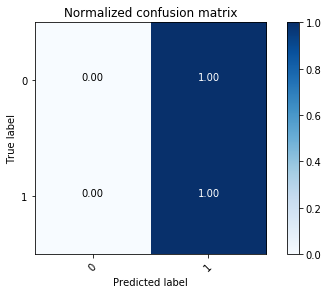

Confusion matrix, without normalization
[[  0 193]
 [  0 139]]
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


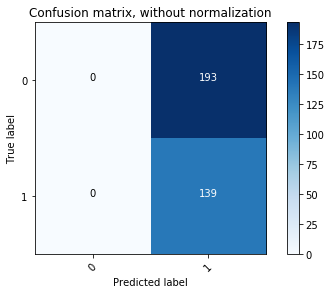

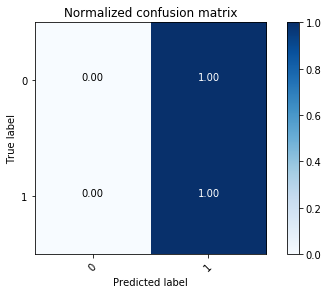

Wall time: 20min 16s


In [30]:
%%time
## MobileNet, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_224_3dim',
                                                    image_size=224, X_train=X_train_224_FML, y_train=y_train_224_FML,
                                                    X_test=X_test_224_FML, y_test=y_test_224_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 57s 19ms/step - loss: 6.7160 - acc: 0.5764 - precision: 0.5764 - recall: 0.5764 - fmeasure: 0.5764
Epoch 2/200
2977/2977 [==============================] - 40s 13ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 3/200
2977/2977 [==============================] - 42s 14ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 4/200
2977/2977 [==============================] - 42s 14ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 5/200
2977/2977 [==============================] - 44s 15ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 6/200
2977/2977 [==============================] - 43s 15ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 7/200
2977/2977 [==============================] - 43s 14m

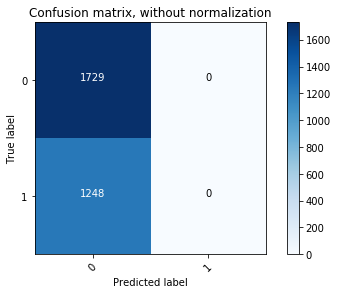

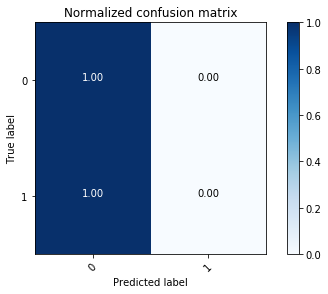

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


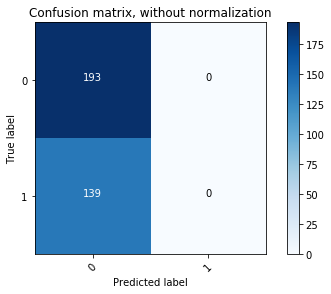

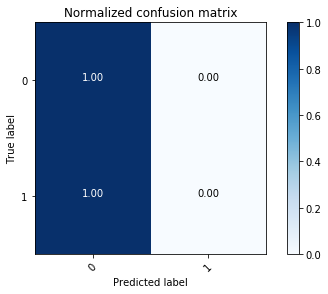

Wall time: 8min 42s


In [31]:
%%time
## SqueezeNet, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_128_3dim',
                                                    image_size=128, X_train=X_train_128_FML, y_train=y_train_128_FML,
                                                    X_test=X_test_128_FML, y_test=y_test_128_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 62s 21ms/step - loss: 6.7437 - acc: 0.5811 - precision: 0.5811 - recall: 0.5811 - fmeasure: 0.5811
Epoch 2/200
2977/2977 [==============================] - 46s 16ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 3/200
2977/2977 [==============================] - 46s 16ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 4/200
2977/2977 [==============================] - 47s 16ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 5/200
2977/2977 [==============================] - 47s 16ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 6/200
2977/2977 [==============================] - 47s 16ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 7/200
2977/2977 [==============================] - 47s 16m

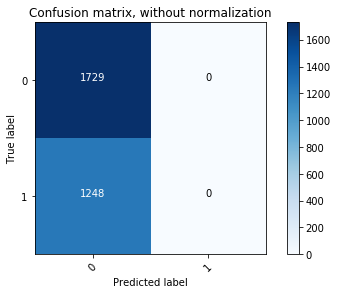

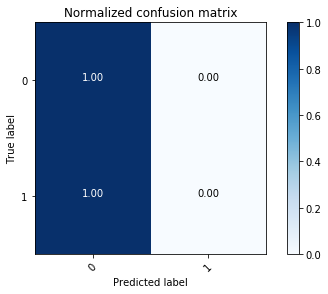

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


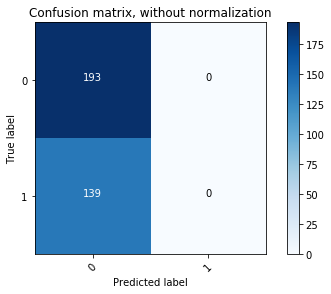

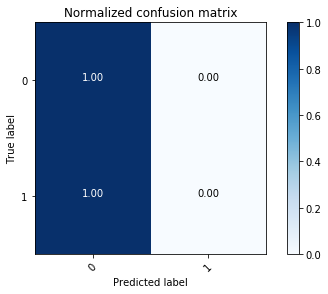

Wall time: 9min 34s


In [32]:
%%time
## SqueezeNet, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_160_3dim',
                                                    image_size=160, X_train=X_train_160_FML, y_train=y_train_160_FML,
                                                    X_test=X_test_160_FML, y_test=y_test_160_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 66s 22ms/step - loss: 6.7569 - acc: 0.5801 - precision: 0.5801 - recall: 0.5801 - fmeasure: 0.5801
Epoch 2/200
2977/2977 [==============================] - 53s 18ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 3/200
2977/2977 [==============================] - 50s 17ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 4/200
2977/2977 [==============================] - 52s 18ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 5/200
2977/2977 [==============================] - 50s 17ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 6/200
2977/2977 [==============================] - 50s 17ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 7/200
2977/2977 [==============================] - 53s 18m

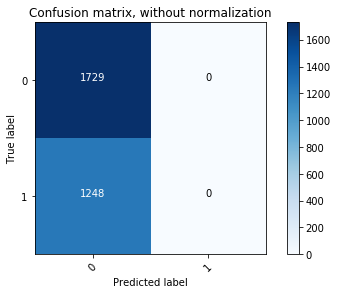

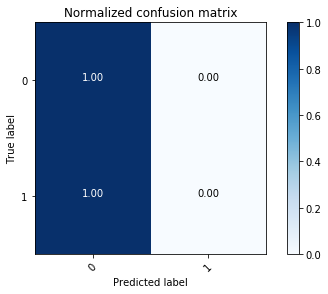

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


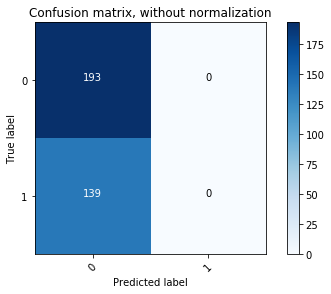

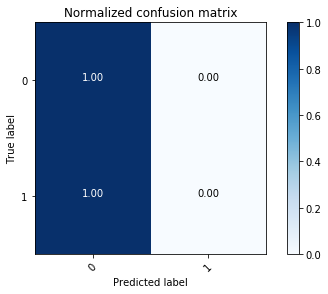

Wall time: 10min 31s


In [33]:
%%time
## SqueezeNet, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_192_3dim',
                                                    image_size=192, X_train=X_train_192_FML, y_train=y_train_192_FML,
                                                    X_test=X_test_192_FML, y_test=y_test_192_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 76s 25ms/step - loss: 9.3054 - acc: 0.4202 - precision: 0.4202 - recall: 0.4202 - fmeasure: 0.4202
Epoch 2/200
2977/2977 [==============================] - 57s 19ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 3/200
2977/2977 [==============================] - 57s 19ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 4/200
2977/2977 [==============================] - 58s 19ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 5/200
2977/2977 [==============================] - 57s 19ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 6/200
2977/2977 [==============================] - 59s 20ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 7/200
2977/2977 [==============================] - 57s 19m

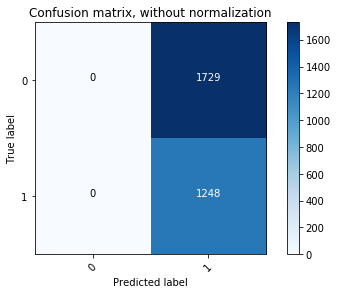

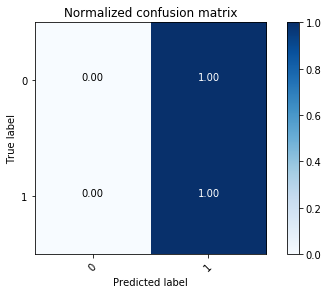

Confusion matrix, without normalization
[[  0 193]
 [  0 139]]
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


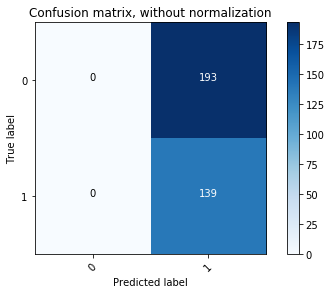

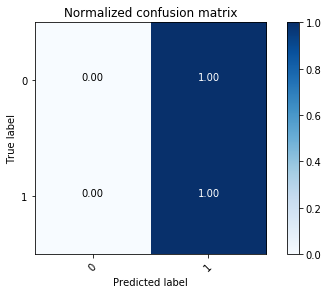

Wall time: 11min 48s


In [34]:
%%time
## SqueezeNet, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_224_3dim',
                                                    image_size=224, X_train=X_train_224_FML, y_train=y_train_224_FML,
                                                    X_test=X_test_224_FML, y_test=y_test_224_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 135s 45ms/step - loss: 0.7020 - acc: 0.5936 - precision: 0.5936 - recall: 0.5936 - fmeasure: 0.5936
Epoch 2/200
2977/2977 [==============================] - 113s 38ms/step - loss: 0.7786 - acc: 0.5741 - precision: 0.5741 - recall: 0.5741 - fmeasure: 0.5741
Epoch 3/200
2977/2977 [==============================] - 115s 38ms/step - loss: 0.7764 - acc: 0.5687 - precision: 0.5687 - recall: 0.5687 - fmeasure: 0.5687
Epoch 4/200
2977/2977 [==============================] - 114s 38ms/step - loss: 0.7886 - acc: 0.5734 - precision: 0.5734 - recall: 0.5734 - fmeasure: 0.5734
Epoch 5/200
2977/2977 [==============================] - 113s 38ms/step - loss: 0.7621 - acc: 0.5791 - precision: 0.5791 - recall: 0.5791 - fmeasure: 0.5791
Epoch 6/200
2977/2977 [==============================] - 113s 38ms/step - loss: 0.7755 - acc: 0.5768 - precision: 0.5768 - recall: 0.5768 - fmeasure: 0.5768
Epoch 7/200
2977/2977 [==============================] - 1

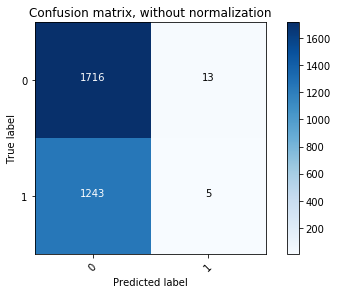

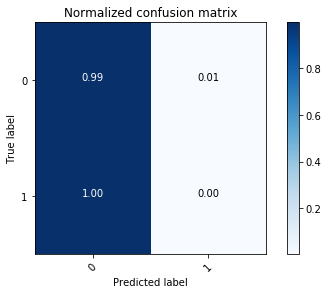

Confusion matrix, without normalization
[[192   1]
 [137   2]]
Normalized confusion matrix
[[0.99481865 0.00518135]
 [0.98561151 0.01438849]]


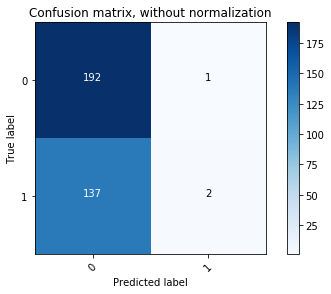

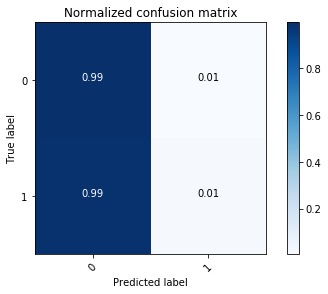

Wall time: 23min 7s


In [35]:
%%time
## Xception, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_128_3dim',
                                                    image_size=128, X_train=X_train_128_FML, y_train=y_train_128_FML,
                                                    X_test=X_test_128_FML, y_test=y_test_128_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 115s 39ms/step - loss: 0.6390 - acc: 0.6755 - precision: 0.6755 - recall: 0.6755 - fmeasure: 0.6755
Epoch 2/200
2977/2977 [==============================] - 101s 34ms/step - loss: 0.4368 - acc: 0.8176 - precision: 0.8176 - recall: 0.8176 - fmeasure: 0.8176
Epoch 3/200
2977/2977 [==============================] - 101s 34ms/step - loss: 0.3574 - acc: 0.8660 - precision: 0.8660 - recall: 0.8660 - fmeasure: 0.8660
Epoch 4/200
2977/2977 [==============================] - 100s 34ms/step - loss: 0.3044 - acc: 0.8808 - precision: 0.8808 - recall: 0.8808 - fmeasure: 0.8808
Epoch 5/200
2977/2977 [==============================] - 101s 34ms/step - loss: 0.4722 - acc: 0.8361 - precision: 0.8361 - recall: 0.8361 - fmeasure: 0.8361
Epoch 6/200
2977/2977 [==============================] - 102s 34ms/step - loss: 1.3604 - acc: 0.6100 - precision: 0.6100 - recall: 0.6100 - fmeasure: 0.6100
Epoch 7/200
2977/2977 [==============================] - 1

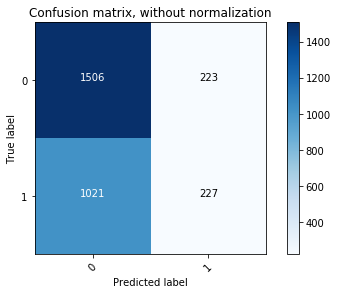

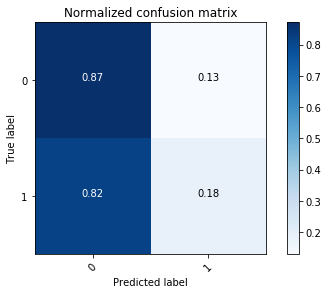

Confusion matrix, without normalization
[[147  46]
 [110  29]]
Normalized confusion matrix
[[0.76165803 0.23834197]
 [0.79136691 0.20863309]]


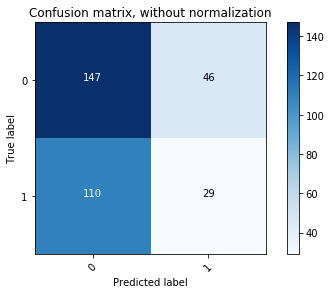

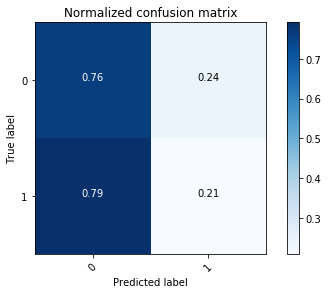

Wall time: 25min 5s


In [36]:
%%time
## Xception, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_128_3dim',
                                                    image_size=128, X_train=X_train_128_FML, y_train=y_train_128_FML,
                                                    X_test=X_test_128_FML, y_test=y_test_128_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 118s 40ms/step - loss: 0.6509 - acc: 0.6466 - precision: 0.6466 - recall: 0.6466 - fmeasure: 0.6466
Epoch 2/200
2977/2977 [==============================] - 102s 34ms/step - loss: 0.5554 - acc: 0.7716 - precision: 0.7716 - recall: 0.7716 - fmeasure: 0.7716
Epoch 3/200
2977/2977 [==============================] - 102s 34ms/step - loss: 0.7842 - acc: 0.7474 - precision: 0.7474 - recall: 0.7474 - fmeasure: 0.7474
Epoch 4/200
2977/2977 [==============================] - 103s 35ms/step - loss: 0.9819 - acc: 0.6298 - precision: 0.6298 - recall: 0.6298 - fmeasure: 0.6298
Epoch 5/200
2977/2977 [==============================] - 102s 34ms/step - loss: 0.9456 - acc: 0.6876 - precision: 0.6876 - recall: 0.6876 - fmeasure: 0.6876
Epoch 6/200
2977/2977 [==============================] - 102s 34ms/step - loss: 0.9055 - acc: 0.7595 - precision: 0.7595 - recall: 0.7595 - fmeasure: 0.7595
Epoch 7/200
2977/2977 [==============================] - 1

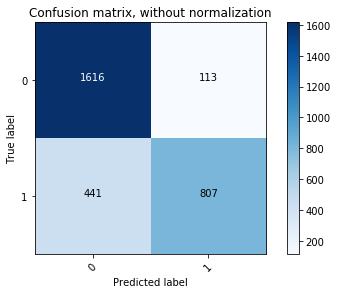

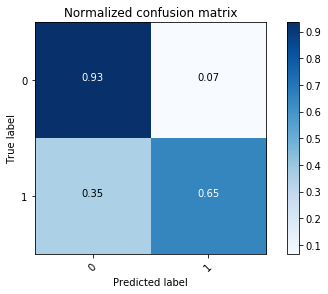

Confusion matrix, without normalization
[[175  18]
 [ 45  94]]
Normalized confusion matrix
[[0.90673575 0.09326425]
 [0.32374101 0.67625899]]


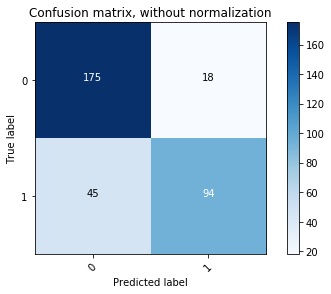

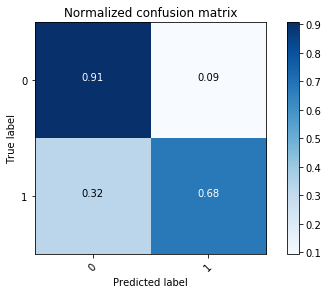

Wall time: 21min 54s


In [37]:
%%time
## Xception, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_128_3dim',
                                                    image_size=128, X_train=X_train_128_FML, y_train=y_train_128_FML,
                                                    X_test=X_test_128_FML, y_test=y_test_128_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 125s 42ms/step - loss: 0.6176 - acc: 0.7115 - precision: 0.7115 - recall: 0.7115 - fmeasure: 0.7115
Epoch 2/200
2977/2977 [==============================] - 108s 36ms/step - loss: 0.6710 - acc: 0.7229 - precision: 0.7229 - recall: 0.7229 - fmeasure: 0.7229
Epoch 3/200
2977/2977 [==============================] - 108s 36ms/step - loss: 1.0017 - acc: 0.6869 - precision: 0.6869 - recall: 0.6869 - fmeasure: 0.6869
Epoch 4/200
2977/2977 [==============================] - 108s 36ms/step - loss: 1.2149 - acc: 0.6150 - precision: 0.6150 - recall: 0.6150 - fmeasure: 0.6150
Epoch 5/200
2977/2977 [==============================] - 109s 36ms/step - loss: 1.4691 - acc: 0.6009 - precision: 0.6009 - recall: 0.6009 - fmeasure: 0.6009
Epoch 6/200
2977/2977 [==============================] - 108s 36ms/step - loss: 1.4667 - acc: 0.6278 - precision: 0.6278 - recall: 0.6278 - fmeasure: 0.6278
Epoch 7/200
2977/2977 [==============================] - 1

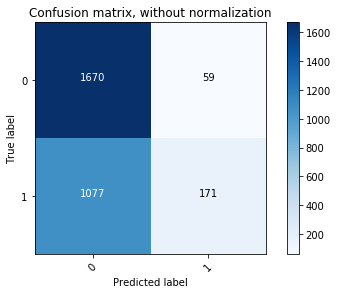

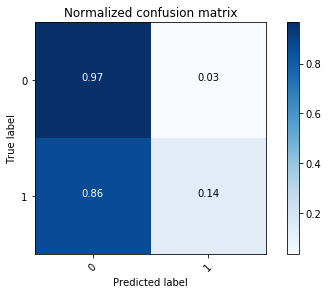

Confusion matrix, without normalization
[[185   8]
 [120  19]]
Normalized confusion matrix
[[0.95854922 0.04145078]
 [0.86330935 0.13669065]]


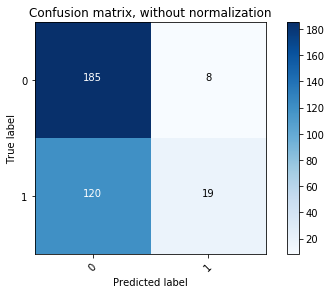

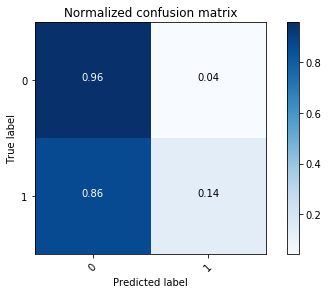

Wall time: 21min 35s


In [40]:
%%time
## Xception, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_160_3dim',
                                                    image_size=160, X_train=X_train_160_FML, y_train=y_train_160_FML,
                                                    X_test=X_test_160_FML, y_test=y_test_160_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 129s 43ms/step - loss: 0.5848 - acc: 0.7612 - precision: 0.7612 - recall: 0.7612 - fmeasure: 0.7612
Epoch 2/200
2977/2977 [==============================] - 108s 36ms/step - loss: 0.5115 - acc: 0.8092 - precision: 0.8092 - recall: 0.8092 - fmeasure: 0.8092
Epoch 3/200
2977/2977 [==============================] - 109s 37ms/step - loss: 0.6093 - acc: 0.8129 - precision: 0.8129 - recall: 0.8129 - fmeasure: 0.8129
Epoch 4/200
2977/2977 [==============================] - 108s 36ms/step - loss: 1.0057 - acc: 0.7941 - precision: 0.7941 - recall: 0.7941 - fmeasure: 0.7941
Epoch 5/200
2977/2977 [==============================] - 108s 36ms/step - loss: 0.8053 - acc: 0.8320 - precision: 0.8320 - recall: 0.8320 - fmeasure: 0.8320
Epoch 6/200
2977/2977 [==============================] - 108s 36ms/step - loss: 0.8903 - acc: 0.8243 - precision: 0.8243 - recall: 0.8243 - fmeasure: 0.8243
Epoch 7/200
2977/2977 [==============================] - 1

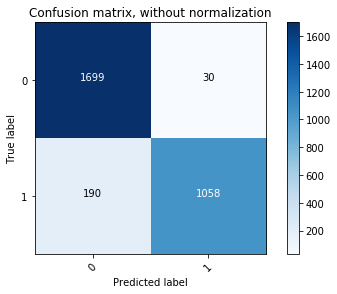

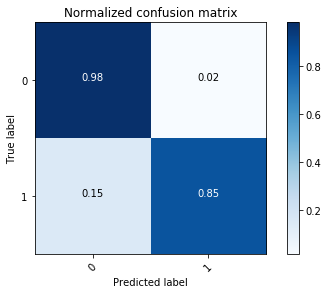

Confusion matrix, without normalization
[[187   6]
 [ 28 111]]
Normalized confusion matrix
[[0.96891192 0.03108808]
 [0.20143885 0.79856115]]


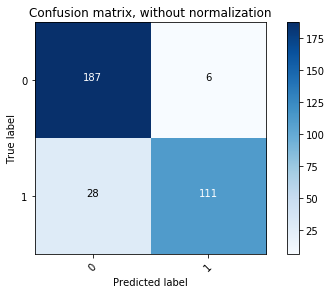

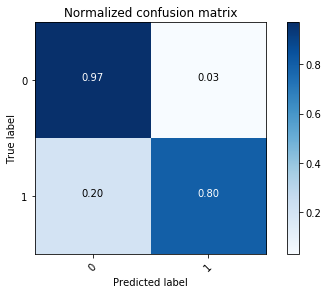

Wall time: 23min 51s


In [41]:
%%time
## Xception, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_192_3dim',
                                                    image_size=192, X_train=X_train_192_FML, y_train=y_train_192_FML,
                                                    X_test=X_test_192_FML, y_test=y_test_192_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 137s 46ms/step - loss: 0.6597 - acc: 0.6745 - precision: 0.6745 - recall: 0.6745 - fmeasure: 0.6745
Epoch 2/200
2977/2977 [==============================] - 118s 40ms/step - loss: 0.8650 - acc: 0.6392 - precision: 0.6392 - recall: 0.6392 - fmeasure: 0.6392
Epoch 3/200
2977/2977 [==============================] - 118s 40ms/step - loss: 0.8757 - acc: 0.5757 - precision: 0.5757 - recall: 0.5757 - fmeasure: 0.5757
Epoch 4/200
2977/2977 [==============================] - 119s 40ms/step - loss: 1.0036 - acc: 0.5744 - precision: 0.5744 - recall: 0.5744 - fmeasure: 0.5744
Epoch 5/200
2977/2977 [==============================] - 119s 40ms/step - loss: 0.9534 - acc: 0.5727 - precision: 0.5727 - recall: 0.5727 - fmeasure: 0.5727
Epoch 6/200
2977/2977 [==============================] - 119s 40ms/step - loss: 1.0054 - acc: 0.5761 - precision: 0.5761 - recall: 0.5761 - fmeasure: 0.5761
Epoch 7/200
2977/2977 [==============================] - 1

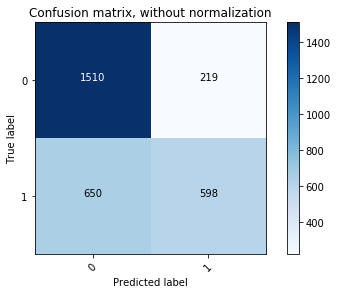

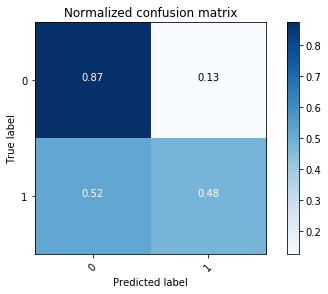

Confusion matrix, without normalization
[[166  27]
 [ 74  65]]
Normalized confusion matrix
[[0.86010363 0.13989637]
 [0.5323741  0.4676259 ]]


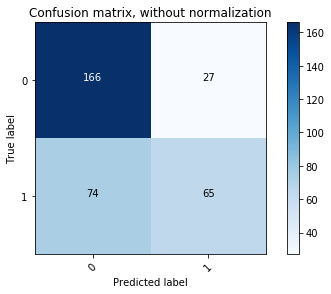

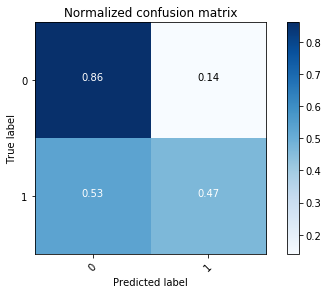

Wall time: 23min 59s


In [42]:
%%time
## Xception, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_224_3dim',
                                                    image_size=224, X_train=X_train_224_FML, y_train=y_train_224_FML,
                                                    X_test=X_test_224_FML, y_test=y_test_224_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 61s 21ms/step - loss: 6.7691 - acc: 0.5794 - precision: 0.5794 - recall: 0.5794 - fmeasure: 0.5794
Epoch 2/200
2977/2977 [==============================] - 43s 14ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 3/200
2977/2977 [==============================] - 43s 14ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 4/200
2977/2977 [==============================] - 43s 14ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 5/200
2977/2977 [==============================] - 43s 15ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 6/200
2977/2977 [==============================] - 43s 15ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 7/200
2977/2977 [==============================] - 43s 15m

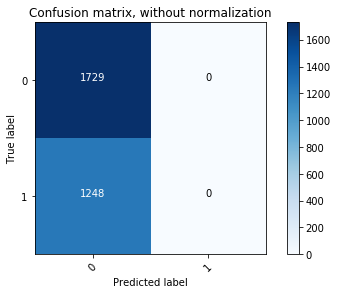

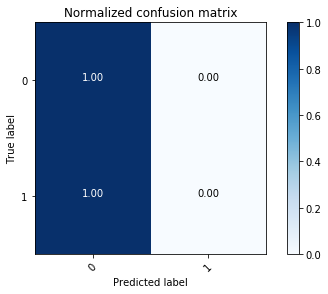

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


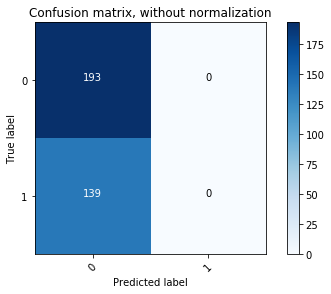

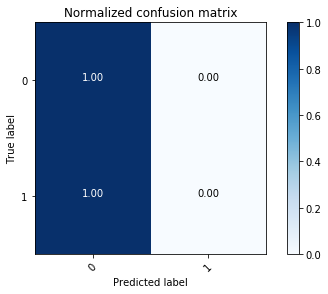

Wall time: 14min 2s


In [43]:
%%time
## VGG16, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_128_3dim',
                                                    image_size=128, X_train=X_train_128_FML, y_train=y_train_128_FML,
                                                    X_test=X_test_128_FML, y_test=y_test_128_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 75s 25ms/step - loss: 6.7546 - acc: 0.5801 - precision: 0.5801 - recall: 0.5801 - fmeasure: 0.5801
Epoch 2/200
2977/2977 [==============================] - 56s 19ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 3/200
2977/2977 [==============================] - 56s 19ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 4/200
2977/2977 [==============================] - 56s 19ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 5/200
2977/2977 [==============================] - 56s 19ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 6/200
2977/2977 [==============================] - 56s 19ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 7/200
2977/2977 [==============================] - 56s 19m

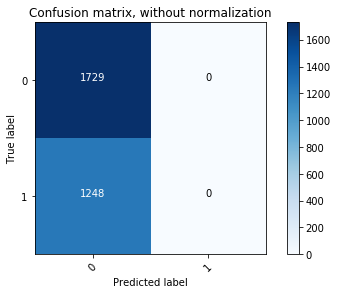

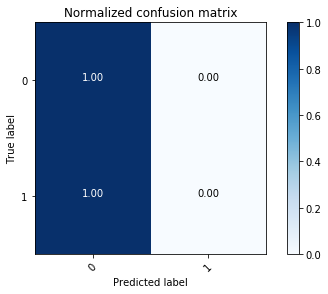

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


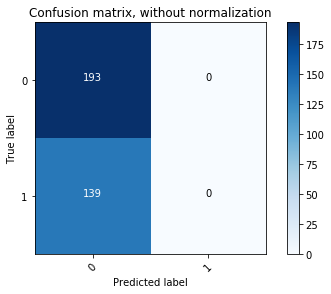

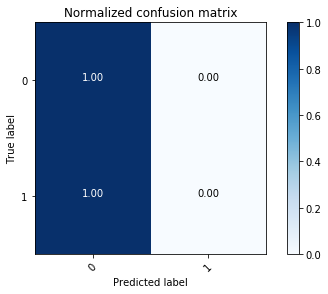

Wall time: 11min 31s


In [44]:
%%time
## VGG16, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_160_3dim',
                                                    image_size=160, X_train=X_train_160_FML, y_train=y_train_160_FML,
                                                    X_test=X_test_160_FML, y_test=y_test_160_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 87s 29ms/step - loss: 6.7612 - acc: 0.5801 - precision: 0.5801 - recall: 0.5801 - fmeasure: 0.5801
Epoch 2/200
2977/2977 [==============================] - 68s 23ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 3/200
2977/2977 [==============================] - 68s 23ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 4/200
2977/2977 [==============================] - 68s 23ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 5/200
2977/2977 [==============================] - 68s 23ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 6/200
2977/2977 [==============================] - 68s 23ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 7/200
2977/2977 [==============================] - 68s 23m

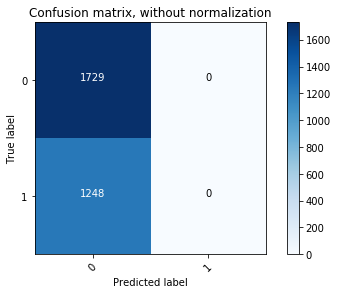

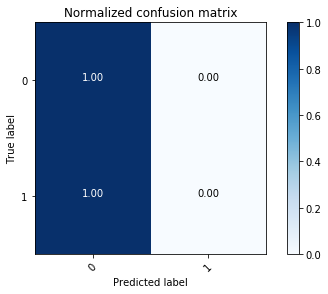

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


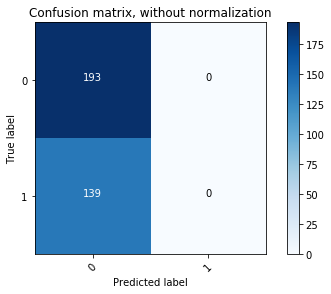

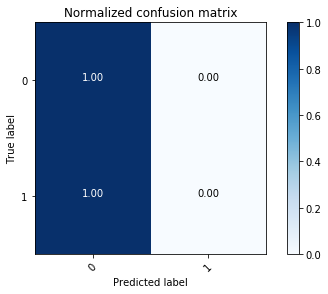

Wall time: 29min 38s


In [45]:
%%time
## VGG16, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_192_3dim',
                                                    image_size=192, X_train=X_train_192_FML, y_train=y_train_192_FML,
                                                    X_test=X_test_192_FML, y_test=y_test_192_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

In [11]:
parameters_df = pd.read_csv('./PARAMETERS_AND_RESULTS/11_04_params_France_WITH_RETRAIN.csv', sep='\t', index_col=0)
results_df = pd.read_csv('./PARAMETERS_AND_RESULTS/11_04_results_France_WITH_RETRAIN.csv', sep='\t', index_col=0)

Epoch 1/200
2977/2977 [==============================] - 85s 29ms/step - loss: 9.3456 - acc: 0.4195 - precision: 0.4195 - recall: 0.4195 - fmeasure: 0.4195
Epoch 2/200
2977/2977 [==============================] - 80s 27ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 3/200
2977/2977 [==============================] - 80s 27ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 4/200
2977/2977 [==============================] - 80s 27ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 5/200
2977/2977 [==============================] - 88s 29ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 6/200
2977/2977 [==============================] - 81s 27ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 7/200
2977/2977 [==============================] - 80s 27m

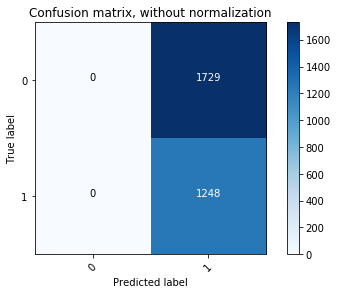

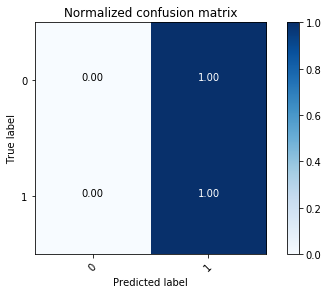

Confusion matrix, without normalization
[[  0 193]
 [  0 139]]
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


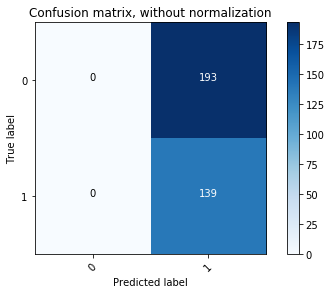

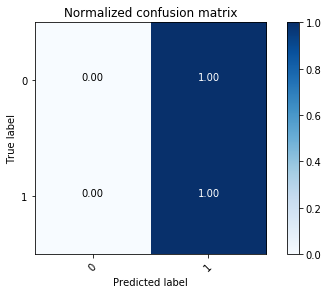

Wall time: 18min 55s


In [12]:
%%time
## VGG16, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_224_3dim',
                                                    image_size=224, X_train=X_train_224_FML, y_train=y_train_224_FML,
                                                    X_test=X_test_224_FML, y_test=y_test_224_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 49s 16ms/step - loss: 6.7516 - acc: 0.5805 - precision: 0.5805 - recall: 0.5805 - fmeasure: 0.5805
Epoch 2/200
2977/2977 [==============================] - 46s 15ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 3/200
2977/2977 [==============================] - 50s 17ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 4/200
2977/2977 [==============================] - 46s 15ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 5/200
2977/2977 [==============================] - 48s 16ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 6/200
2977/2977 [==============================] - 48s 16ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 7/200
2977/2977 [==============================] - 114s 38

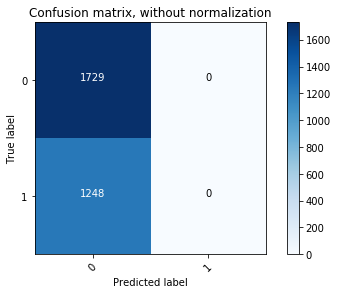

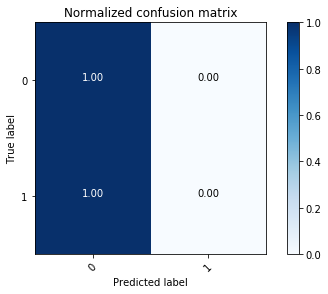

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


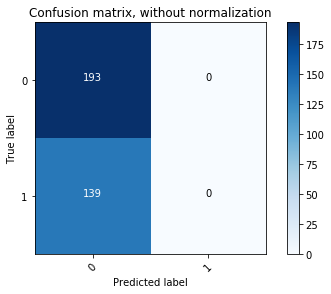

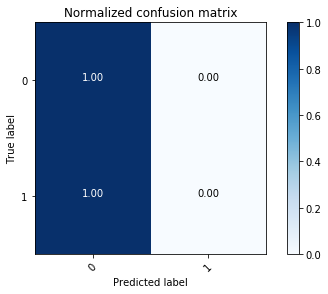

Wall time: 10min 14s


In [13]:
%%time
## VGG19, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_128_3dim',
                                                    image_size=128, X_train=X_train_128_FML, y_train=y_train_128_FML,
                                                    X_test=X_test_128_FML, y_test=y_test_128_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

In [11]:
parameters_df = pd.read_csv('./PARAMETERS_AND_RESULTS/11_04_params_France_WITH_RETRAIN.csv', sep='\t', index_col=0)
results_df = pd.read_csv('./PARAMETERS_AND_RESULTS/11_04_results_France_WITH_RETRAIN.csv', sep='\t', index_col=0)

Epoch 1/200
2977/2977 [==============================] - 67s 22ms/step - loss: 9.3630 - acc: 0.4189 - precision: 0.4189 - recall: 0.4189 - fmeasure: 0.4189
Epoch 2/200
2977/2977 [==============================] - 63s 21ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 3/200
2977/2977 [==============================] - 62s 21ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 4/200
2977/2977 [==============================] - 62s 21ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 5/200
2977/2977 [==============================] - 62s 21ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 6/200
2977/2977 [==============================] - 62s 21ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 7/200
2977/2977 [==============================] - 62s 21m

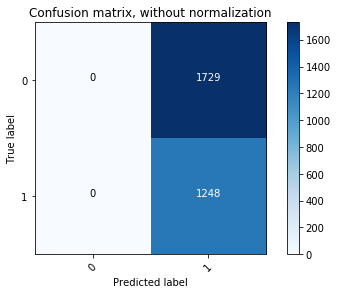

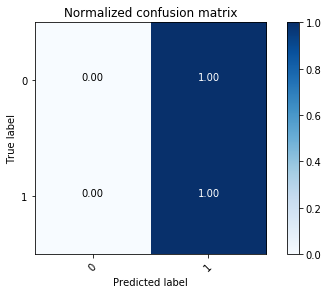

Confusion matrix, without normalization
[[  0 193]
 [  0 139]]
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


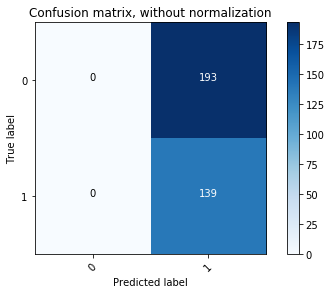

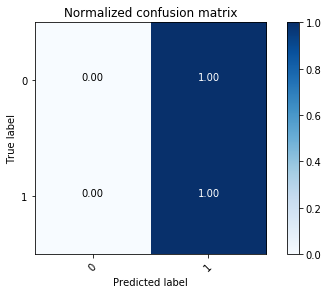

Wall time: 20min 10s


In [12]:
%%time
## VGG19, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_160_3dim',
                                                    image_size=160, X_train=X_train_160_FML, y_train=y_train_160_FML,
                                                    X_test=X_test_160_FML, y_test=y_test_160_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 79s 27ms/step - loss: 9.3400 - acc: 0.4202 - precision: 0.4202 - recall: 0.4202 - fmeasure: 0.4202
Epoch 2/200
2977/2977 [==============================] - 76s 25ms/step - loss: 9.3558 - acc: 0.4195 - precision: 0.4195 - recall: 0.4195 - fmeasure: 0.4195
Epoch 3/200
2977/2977 [==============================] - 75s 25ms/step - loss: 9.3666 - acc: 0.4189 - precision: 0.4189 - recall: 0.4189 - fmeasure: 0.4189
Epoch 4/200
2977/2977 [==============================] - 76s 25ms/step - loss: 9.3503 - acc: 0.4199 - precision: 0.4199 - recall: 0.4199 - fmeasure: 0.4199
Epoch 5/200
2977/2977 [==============================] - 76s 26ms/step - loss: 9.3395 - acc: 0.4206 - precision: 0.4206 - recall: 0.4206 - fmeasure: 0.4206
Epoch 6/200
2977/2977 [==============================] - 77s 26ms/step - loss: 9.3558 - acc: 0.4195 - precision: 0.4195 - recall: 0.4195 - fmeasure: 0.4195
Epoch 7/200
2977/2977 [==============================] - 76s 26m

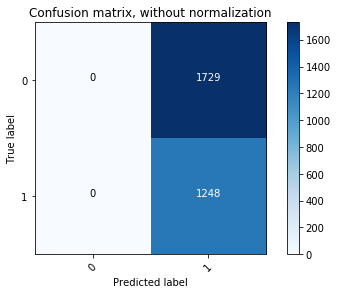

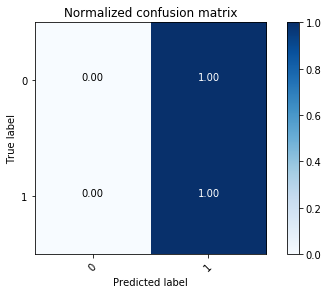

Confusion matrix, without normalization
[[  0 193]
 [  0 139]]
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


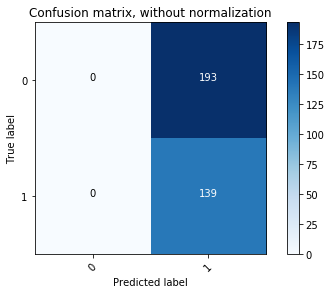

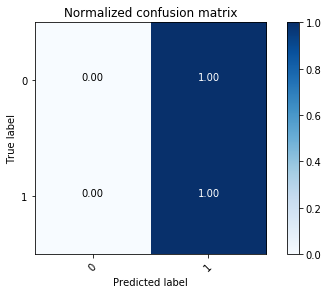

Wall time: 19min 38s


In [13]:
%%time
## VGG19, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_192_3dim',
                                                    image_size=192, X_train=X_train_192_FML, y_train=y_train_192_FML,
                                                    X_test=X_test_192_FML, y_test=y_test_192_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 100s 33ms/step - loss: 6.7775 - acc: 0.5791 - precision: 0.5791 - recall: 0.5791 - fmeasure: 0.5791
Epoch 2/200
2977/2977 [==============================] - 96s 32ms/step - loss: 6.7894 - acc: 0.5788 - precision: 0.5788 - recall: 0.5788 - fmeasure: 0.5788
Epoch 3/200
2977/2977 [==============================] - 96s 32ms/step - loss: 6.7461 - acc: 0.5815 - precision: 0.5815 - recall: 0.5815 - fmeasure: 0.5815
Epoch 4/200
2977/2977 [==============================] - 96s 32ms/step - loss: 6.7678 - acc: 0.5801 - precision: 0.5801 - recall: 0.5801 - fmeasure: 0.5801
Epoch 5/200
2977/2977 [==============================] - 96s 32ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 6/200
2977/2977 [==============================] - 96s 32ms/step - loss: 6.7678 - acc: 0.5801 - precision: 0.5801 - recall: 0.5801 - fmeasure: 0.5801
Epoch 7/200
2977/2977 [==============================] - 96s 32

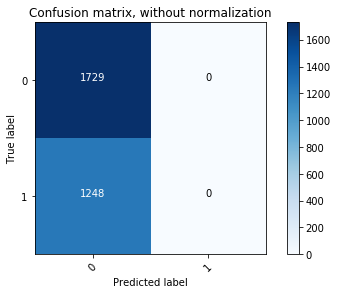

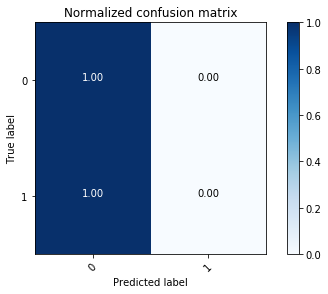

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


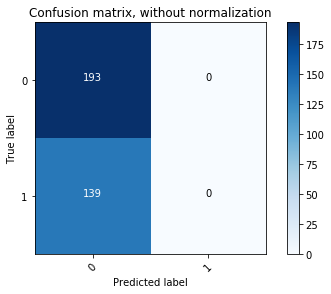

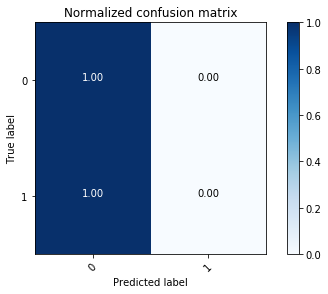

Wall time: 32min 39s


In [14]:
%%time
## VGG19, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_224_3dim',
                                                    image_size=224, X_train=X_train_224_FML, y_train=y_train_224_FML,
                                                    X_test=X_test_224_FML, y_test=y_test_224_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)